In [ ]:
from itertools import combinations
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn import set_config
import joblib
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from pandas.api.types import is_numeric_dtype
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline as SklearnPipeline
from imblearn.pipeline import Pipeline as ImblearnPipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import ADASYN
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.ensemble import StackingClassifier
from sklearn.calibration import CalibrationDisplay
from matplotlib.ticker import PercentFormatter
import shap

Estamos refinando o conjunto de dados principal para atender a um objetivo comercial claro: criar um modelo que preveja o resultado acadêmico final de um aluno. Para fazer isso de forma eficaz, o modelo deve ser treinado em dados com resultados históricos confirmados. Os registros de alunos que ainda estão “Matriculados” representam um status incerto, em andamento, e não um resultado final. A inclusão dessa ambiguidade introduziria ruído e comprometeria a capacidade do modelo de aprender os padrões distintos que diferenciam os alunos que acabam se formando dos que desistem.


O arquivo exportado que contém os alunos “matriculados” é preservado para a aplicação principal do modelo. Depois que nosso modelo for treinado e validado nos dados históricos, nós o usaremos para prever os resultados futuros para esse grupo de “matriculados”. Isso nos permite gerar uma pontuação de risco de evasão para cada aluno ativo no momento, permitindo que a instituição identifique proativamente indivíduos em risco e implemente intervenções direcionadas para melhorar a retenção.

In [7]:
df = pd.read_csv('./data/dataset.csv')

enrolled_df = df[df['Target'] == 'Enrolled'].copy()
enrolled_df.to_csv('./data/enrolled_students.csv', index=False)

df = df[df['Target'] != 'Enrolled']

cols_to_convert_to_category = [
    'Marital status', 'Application mode', 'Course', 'Daytime/evening attendance',
    'Previous qualification', 'Nacionality', "Mother's qualification", 
    "Father's qualification", "Mother's occupation", "Father's occupation", 
    'Displaced', 'Educational special needs', 'Debtor', "Target",
    'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International'
]

for col in cols_to_convert_to_category:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Analise Exploratória dos Dados

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Target', data=df, palette=['#E74C3C', '#2ECC71'])

plt.title('Distribuição de Alunos: Evasão vs. Graduados', fontsize=16)
plt.xlabel('Resultado Acadêmico Final', fontsize=12)
plt.ylabel('Número de Alunos', fontsize=12)

total = len(df['Target'])
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

plt.show()

Este gráfico mostra a proporção exata entre evasões e formaturas. As classes estão muito desbalanceadas (ex: 60.9% de graduados e 39.1% de evasão), talvez seja necessário usar técnicas de amostragem (como SMOTE ou ADASYN), métricas de avaliação específicas (como F1-Score) e uso de peso de classes durante a modelagem.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Impacto de Fatores Financeiros na Evasão Escolar', fontsize=18)

sns.countplot(ax=axes[0], x='Debtor', hue='Target', data=df, palette='viridis')
axes[0].set_title('Resultado por Situação de Dívida')
axes[0].set_xticklabels(['Não Devedor', 'Devedor'])

sns.countplot(ax=axes[1], x='Tuition fees up to date', hue='Target', data=df, palette='magma')
axes[1].set_title('Resultado por Status da Mensalidade')
axes[1].set_xticklabels(['Em Atraso', 'Em Dia'])

sns.countplot(ax=axes[2], x='Scholarship holder', hue='Target', data=df, palette='plasma')
axes[2].set_title('Resultado por Status de Bolsista')
axes[2].set_xticklabels(['Não Bolsista', 'Bolsista'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Os gráficos mostram que ter dívidas ou mensalidades em atraso está fortemente correlacionado com a evasão. Por outro lado, ser bolsista tende a estar associado a uma maior taxa de graduação, possivelmente por reduzir a pressão financeira e selecionar alunos com bom desempenho.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Desempenho Acadêmico no 1º Semestre como Preditivo de Evasão', fontsize=18)

sns.boxplot(ax=axes[0], x='Target', y='Curricular units 1st sem (approved)', data=df, palette=['#E74C3C', '#2ECC71'])
axes[0].set_title('Unidades Curriculares Aprovadas (1º Sem)')
axes[0].set_xlabel('Resultado Final')
axes[0].set_ylabel('Nº de Unidades Aprovadas')


sns.kdeplot(data=df, x='Curricular units 1st sem (grade)', hue='Target',
            fill=True, common_norm=False, palette=['#E74C3C', '#2ECC71'])
axes[1].set_title('Distribuição das Notas (1º Sem)')
axes[1].set_xlabel('Nota Média')
axes[1].set_ylabel('Densidade')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Fica evidente que alunos que aprovam mais matérias e têm notas mais altas logo no primeiro semestre têm uma chance muito maior de se graduar. Uma baixa contagem de aprovações é um forte sinal de alerta precoce para a evasão.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Análise de Fatores de Ingresso', fontsize=18)

sns.countplot(ax=axes[0], x='Application order', hue='Target', data=df, palette='coolwarm')
axes[0].set_title('Resultado por Preferência de Curso na Inscrição')
axes[0].set_xlabel('Ordem de Preferência (1 = 1ª Escolha)')
axes[0].set_ylabel('Número de Alunos')

sns.violinplot(ax=axes[1], x='Target', y='Age at enrollment', data=df, palette=['#E74C3C', '#2ECC71'])
axes[1].set_title('Resultado por Idade de Ingresso')
axes[1].set_xlabel('Resultado Final')
axes[1].set_ylabel('Idade de Ingresso')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Alunos que entram no curso de primeira escolha (Application order = 1) intuitivamente tendem a ser mais motivados e, consequentemente, têm uma taxa de evasão menor, mas o grafico acima nos mostra que a proporção de graduados e evasão continua a mesma quanto aumenta a Ordem de Preferência. A análise de idade pode revelar que alunos mais velhos (mature students) tem taxas de evasão ligeiramente maiores, talvez por terem que conciliar trabalho, estudo, família e outras responsabilidades que se tem quando é mais velho.

## Analise Estatística

| Tipo de variável 1 | Tipo de variável 2 | Teste recomendado | Observação |
| :--- | :--- | :--- | :--- |
| Categórica | Categórica | Qui-quadrado (Chi-square) | Testa independência entre categorias |
| Numérica | Numérica | Correlação de Pearson (ou Spearman para não paramétrico) | Mede força e direção da relação linear |
| Categórica | Numérica | ANOVA (ou teste t para 2 grupos) | Testa diferença das médias da numérica entre grupos categóricos |
| Numérica | Categórica | ANOVA (mesma situação acima, só invertendo) | O teste é simétrico neste caso |
| Categórica (target) | Numérica | Modelos de classificação (e.g., regressão logística) e testes específicos | ANOVA não é indicado para associação com target categórico |
| Numérica (target) | Categórica | ANOVA (comparar médias entre grupos da categórica) | Clássico caso para ANOVA |

### Matriz de correlação de Pearson (Entre variáveis númericas)

É uma tabela que mostra o grau de associação linear entre pares de variáveis numéricas.

Ela usa o coeficiente de correlação de Pearson (r) para medir quanto duas variáveis se movem juntas, ou seja, o quanto aumentos ou diminuições em uma variável se associam a aumentos ou diminuições em outra.

| Valor de r | Interpretação |
| :--- | :--- |
| +1 | Correlação linear positiva perfeita |
| 0 | Sem correlação linear |
| -1 | Correlação linear negativa perfeita |

**Importante**: Pearson só mede relações lineares. Duas variáveis podem ser dependentes não-linearmente e ainda assim ter r ≈ 0.

Para duas variáveis X e Y com n observações, o coeficiente de correlação de Pearson r é calculado como:

$$
r = \frac{\sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})}
         {\sqrt{\sum_{i=1}^{n} (X_i - \bar{X})^2} \cdot \sqrt{\sum_{i=1}^{n} (Y_i - \bar{Y})^2}}
$$

Onde:
- $Xᵢ$ e $Yᵢ$ são os valores individuais das variáveis $X$ e $Y$
- $𝑋̄$ e $𝑌̄$ são as médias das variáveis $X$ e $Y$
- O numerador é a covariância entre $X$ e $Y$
- O denominador é o produto dos desvios padrão de $X$ e $Y$

In [ ]:
numeric_cols = df.select_dtypes(include=np.number)

corr_matrix = numeric_cols.corr()

plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title('Heatmap de Correlação das Variáveis Numéricas', fontsize=18)
plt.show()

- **Dentro do mesmo semestre**: Variáveis como unidades matriculadas (enrolled), avaliadas (evaluations) e aprovadas (approved) são fortemente correlacionadas. Isso é lógico: quem se matricula em mais matérias tende a ter mais avaliações e a ser aprovado em mais unidades. A nota do semestre (grade) também tem uma correlação muito forte com as unidades aprovadas (approved), com um valor de 0.71 no 1º semestre.

- **Entre semestres (Insight importante)**: A correlação mais forte e importante é entre o desempenho do 1º e do 2º semestre. A nota do 1º semestre (1st sem (grade)) tem uma correlação de 0.85 com a do 2º. Da mesma forma, as unidades aprovadas no 1º semestre têm correlação de 0.92 com as do 2º. Isso prova que o desempenho acadêmico passado é um preditor extremamente forte do desempenho futuro.

- **Possível Multicolinearidade**: O "bloco quente" envolvendo as variáveis `Curricular units ...` são um grande indicativo de multicolinearidade. Isso será analisado posteriormente usando a técnica de Fator de Inflação de Variância (VIF).

### Testes de Hipótese


#### ANOVA (Análise de Variância): 
Testa se existe uma diferença estatisticamente significativa entre as médias de uma variável numérica em dois ou mais grupos de uma variável categórica

- **ANOVA pergunta**: "Essa variável categórica está associada a diferenças significativas na média de uma variável contínua?"
    - Se sim, ela traz informação útil e pode ser uma boa candidata como variável explicativa.

1. **Hipótese nula** ($H_0$):
    - Não há diferença significativa entre os grupos.
    - Ou seja: a variável categórica não tem efeito sobre a variável numérica.
    - As médias dos grupos (categorias) são iguais.

➡ Isso implica que não há associação estatística entre as variáveis. É possível considerar o descarte de uma das variáveis, ou realizar um feature engineering.

2. **Hipótese alternativa** ($H_1$):
    - Há pelo menos uma diferença significativa entre os grupos.
    - Ou seja: a variável categórica tem efeito sobre a variável numérica.
    - As médias dos grupos são diferentes.

➡ Isso indica associação significativa entre a variável categórica e a numérica. Feature engineering pode não ser necessária nesse ponto, porque a relação já está clara, mas ainda pode valer a pena melhorar a representação.

- $p > 0.05$ >>> Não rejeita $H_0$ → Não há evidência de diferença entre os grupos → Sem associação
- $p ≤ 0.05$ >>> Rejeita $H_0$ e aceita $H_1$ → Existe evidência de que os grupos diferem → Há associação

In [ ]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=np.number).columns.tolist()

if 'Target' in categorical_features:
    categorical_features.remove('Target')

anova_results = []

for cat_col in categorical_features:
    for num_col in numerical_features:
        # Pular se a variável categórica tiver muitas categorias (torna o teste lento/ruim)
        if df[cat_col].nunique() > 50:
            continue
            
        # Agrupar os dados numéricos pelas categorias da variável categórica
        groups = df.groupby(cat_col)[num_col].apply(list)
        
        if len(groups) < 2:
            continue
        
        try:
            f_statistic, p_value = f_oneway(*groups)
            anova_results.append({
                'Variável Categórica': cat_col,
                'Variável Numérica': num_col,
                'Estatístfor o núcleoica F': f_statistic,
                'p-valor': p_value
            })
        except Exception as e:
            # Ignorar pares que causam erros (ex: grupos com dados insuficientes)
            pass

results_df = pd.DataFrame(anova_results)

results_df_sorted = results_df.sort_values(by='p-valor', ascending=True)

print("Exibindo as 15 relações mais significativas:")
display(results_df_sorted.head(15))

print("Exibindo as 15 relações menos significativas:")
display(results_df_sorted.tail(15))


- **Idade de Ingresso (Age at enrollment) é Central**: A idade do aluno é a variável numérica mais influenciada por fatores categóricos. Ela está fortemente associada ao Estado Civil, Modo de Aplicação, Curso, Qualificação Prévia e se o aluno é Deslocado. Isso indica que diferentes perfis demográficos ingressam na universidade em idades significativamente diferentes, o que, por si só, é um poderoso agrupador de comportamento.

- **O Curso (Course) Define o Desempenho**: Como esperado, o curso escolhido tem um impacto massivo em todas as métricas de desempenho acadêmico: unidades matriculadas (enrolled), notas (grade) e unidades aprovadas (approved). Isso confirma que a dificuldade e a carga de trabalho variam drasticamente entre os cursos, tornando esta uma das features mais importantes para prever o sucesso de um aluno.

- **O Histórico Importa**: A Qualificação Prévia (Previous qualification) e o Modo de Aplicação (Application mode) estão fortemente ligados tanto à idade quanto aos créditos iniciais. Isso mostra que a "bagagem" que o aluno traz para a universidade já o coloca em uma trajetória de desempenho distinta.

- **Status de International é um Preditor Fraco (Isoladamente)**: A descoberta mais notável aqui é que ser ou não um estudante internacional não tem uma associação estatisticamente significativa com quase nenhuma métrica de desempenho acadêmico (notas, aprovações, avaliações). Isso sugere que, neste dataset, o desempenho dos alunos internacionais é estatisticamente indistinguível do dos alunos nacionais, tornando essa variável, sozinha, um preditor fraco.

- **Demografia Secundária com Baixo Impacto**: Variáveis como Ocupação do Pai (Father's occupation), Nacionalidade (Nacionality) e Gênero (Gender), quando cruzadas com as métricas numéricas, mostraram uma relação muito fraca (p-valor alto). Elas provavelmente têm menos poder preditivo direto do que as variáveis da primeira tabela.

- **Fatores Macroeconômicos Difusos**: A Taxa de Inflação e o PIB não se mostraram associados a características individuais como gênero ou nacionalidade, o que faz sentido, pois são indicadores que afetam a todos de forma mais ampla e menos direta.


#### Qui-Quadrado

Este teste avalia se existe uma associação estatisticamente significativa entre duas variáveis categóricas. A hipótese nula $H_0​$ é que as variáveis são independentes (não há associação, com $p > 0.05$) e a hipótese alternativa $H_1$ é que existe uma associação ($p ≤ 0.05$).

O Qui-Quadrado consegue analisar associações entre a nossa variável Target (que é categórica) e outras variáveis explicativas categóricas.

**OBS**: A ANOVA analisa o impacto de uma variável categórica nas médias de uma variável numérica, A variável categórica define os grupos (por exemplo: `aprovado`, `reprovado`, `evadiu`), e a variável numérica é a que está sendo analisada em relação às diferenças entre esses grupos (ex: média de notas, horas de estudo, renda etc.). No nosso caso, queremos sabe se a variável categórica `Target` (evasão escolar) pode ser explicada por uma variável numérica (ex: renda, idade, nota), acontece que a ANOVA não foi projetada para testar isso diretamente, porque o foco da ANOVA está na variável numérica como variável de interesse, e a categórica como variável explicativa, e não o contrário. O teste de **Qui-quadrado** entra para resolver esse problema.

In [ ]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_pairs = list(combinations(categorical_features, 2))
chi2_results = []

for pair in cat_pairs:
    var1, var2 = pair[0], pair[1]
    
    contingency_table = pd.crosstab(df[var1], df[var2])
    
    try:
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        chi2_results.append({
            'Variável 1': var1,
            'Variável 2': var2,
            'Estatística Chi2': chi2,
            'p-valor': p_value
        })
    except Exception as e:
        # Algumas tabelas podem ter contagens zero, o que pode falhar o teste
        pass

results_df = pd.DataFrame(chi2_results)

results_df_sorted = results_df.sort_values(by='p-valor', ascending=True)

print("Relações mais significativas:")
display(results_df_sorted.head(20))

print("\n\nAssociações mais fortes com a variável 'Target':")
target_associations = results_df_sorted[
    (results_df_sorted['Variável 1'] == 'Target') | (results_df_sorted['Variável 2'] == 'Target')
].copy()
display(target_associations.head(20))

target_associations['Feature'] = target_associations.apply(
    lambda row: row['Variável 1'] if row['Variável 2'] == 'Target' else row['Variável 2'],
    axis=1
)

target_associations['Força da Associação (-log10 p-valor)'] = -np.log10(target_associations['p-valor'].replace(0, 1e-300))

plot_data = target_associations.sort_values(by='Força da Associação (-log10 p-valor)', ascending=False)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 10))
ax = sns.barplot(
    data=plot_data,
    x='Força da Associação (-log10 p-valor)',
    y='Feature',
    palette='viridis_r',
    orient='h'
)

ax.set_title("Força da Associação das Variáveis Categóricas com o 'Target'", fontsize=18, pad=20)
ax.set_xlabel('Força da Associação (-log10 do p-valor)  <-- Mais Forte', fontsize=12)
ax.set_ylabel('Variável Categórica', fontsize=12)

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.5, p.get_y() + p.get_height() / 2,
            f'{width:.1f}',
            va='center',
            fontsize=11)

plt.tight_layout()
plt.show()


##### Tier 1: Os Preditores Dominantes (p-valor $< e-50$)

Estas são as variáveis com a conexão mais forte com a evasão. Elas devem estar presentes em qualquer modelo preditivo que for construído.

- **Tuition fees up to date (Mensalidades em dia)**: Com um p-valor astronômico de aproximadamente $e^-156$, esta é, de longe, a variável mais impactante. A associação é tão forte que o status financeiro do aluno com a instituição é quase um veredito sobre seu resultado. A mensagem é clara: dificuldade financeira é a principal causa de evasão.

- **Course (Curso)**: A segunda variável mais forte. Confirma que o curso escolhido pelo aluno é um fator determinante para seu sucesso. Alguns cursos podem ter taxas de evasão intrinsecamente mais altas devido à dificuldade, estrutura ou alinhamento com o mercado.

- **Scholarship holder (Bolsista)**: Funciona como o oposto do status da mensalidade. Ter uma bolsa, que alivia a pressão financeira e muitas vezes seleciona alunos de alto mérito, tem um efeito protetor massivo contra a evasão.

- **Application mode (Modo de Ingresso) e Debtor (Devedor)**: Completam este grupo de variáveis significativas. O caminho pelo qual o aluno entrou na universidade e seu status de dívida são fatores críticos.

- **Gender (Gênero)**: Surpreendentemente, Gênero aparece com uma associação extremamente forte. Isso não significa que um gênero seja "melhor" que o outro, mas sim que, neste dataset, os padrões de evasão e graduação entre homens e mulheres são estatisticamente muito diferentes. Seria interessante investigar isso mais a fundo (ex: evasão por gênero dentro de cada curso).

Insight Principal do Tier 1: A saúde financeira do aluno e suas escolhas acadêmicas primárias são os pilares que sustentam sua jornada na universidade.

##### Tier 2: Os Fatores de Contexto (p-valor entre $e-10$ e $e-24$)

Estas variáveis, embora não tão dominantes quanto as do Tier 1, ainda são preditores muito fortes e adicionam um ótimo contexto sobre o perfil do aluno.

- **Qualificação e Ocupação dos Pais (Mother's/Father's qualification/occupation)**: Este bloco de variáveis age como um forte indicador do background socioeconômico e cultural do aluno. Um nível educacional mais alto dos pais está claramente associado a uma menor chance de evasão, provavelmente por indicar um ambiente familiar que valoriza mais a educação e oferece maior suporte.

- **Histórico Acadêmico (Previous qualification)**: A formação anterior do aluno continua sendo um preditor robusto do seu sucesso futuro.

- **Circunstâncias Pessoais (Displaced, Marital status, Daytime/evening attendance)**: Fatores que descrevem a "vida fora da universidade" do aluno também têm um peso significativo. Ser deslocado (longe de casa), o estado civil e estudar à noite (geralmente indicando um trabalho simultâneo) são circunstâncias que impactam diretamente a capacidade do aluno de se manter no curso.

Insight Principal do Tier 2: O contexto social, familiar e pessoal do aluno fornece a segunda camada mais importante de informação preditiva.

##### Tier 3: Preditores Marginais ou Fracos (p-valor $> e-01$)

Estas variáveis estão na parte inferior da lista e devem ser tratadas com cautela, pois podem adicionar mais ruído a um modelo do que ajudar na previsão da variável target.

- **Nacionality (Nacionalidade)**: Embora ainda seja estatisticamente significativa (p-valor ~0.034 < 0.05), sua força de associação é ordens de magnitude mais fraca que a dos outros grupos. Ela pode adicionar alguma informação, mas seu impacto é pequeno.

- **Educational special needs (Necessidades Especiais) e International (Internacional)**: Com p-valores de ~0.78 e ~0.79, respectivamente, estas variáveis não têm uma associação estatisticamente significativa com o Target. Isso confirma o que já havíamos visto no teste ANOVA para International. Isso pode significar que o suporte da instituição para esses grupos é eficaz, ou que outros fatores são tão dominantes que anulam o efeito isolado dessas condições.

Insight Principal do Tier 3: Contrariando o senso comum, ser um estudante internacional ou ter uma necessidade especial registrada não são, por si só, fatores de risco para evasão neste dataset

### Fator de Inflação de Variância (VIF) - Diagnóstico de Multicolinearidade

Para uma variável $X_i$, o $VIF$ é definido como:

$$
\text{VIF}_i = \frac{1}{1 - R_i^2}
$$

Onde:

- $R_i^2$ é o coeficiente de determinação da regressão da variável $X_i$ sobre todas as outras variáveis explicativas.

O VIF pergunta: "Essa variável está altamente correlacionada com as demais variáveis do modelo?"
- Se sim, traz redundância e pode prejudicar a interpretação da regressão.

In [ ]:
# X_dum = pd.get_dummies(df, drop_first=True)
# X_dum = X_dum.astype(float)
# X_const = add_constant(X_dum)

X_numeric = df.select_dtypes(include=np.number).dropna()
X_const = add_constant(X_numeric)

vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

top_vif = vif_data[vif_data['feature'] != 'const'].sort_values("VIF", ascending=False).head(50)

plt.figure(figsize=(12, 10))
plt.barh(top_vif["feature"], top_vif["VIF"], color="skyblue")
plt.xlabel("VIF")
plt.ylabel("Feature")
plt.title("Top 50 Variáveis com Maior VIF (Multicolinearidade)")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### Interpretação dos Valores de VIF

- $VIF = 1$ : Sem multicolinearidade 
- $1 < VIF < 5$ : Baixa multicolinearidade 
- $5 < VIF < 10$ : Moderada multicolinearidade (atenção)
- $VIF > 10$ : Alta multicolinearidade (problemático)

Um valor alto de VIF é problemático por várias razões. Primeiro, ele indica coeficientes instáveis, pois o modelo tem dificuldade em distinguir os efeitos individuais das variáveis correlacionadas. Além disso, há redundância, já que a variável com VIF alto geralmente não adiciona nova informação, podendo ser prevista pelas demais. Isso também pode levar a overfitting, pois o modelo se ajusta em excesso aos dados de treino ao incorporar variáveis que não contribuem efetivamente para a explicação da variável alvo. Por fim, há uma dificuldade de interpretação, já que se torna confuso identificar qual variável está realmente impactando a resposta.


- **VIF Extremamente Alto (> 10)**: As variáveis Curricular units 1st/2nd sem (enrolled), (credited) e (approved) apresentam VIFs altíssimos, chegando a 24.08. Isso significa que mais de 95% da variância de Curricular units 1st sem (enrolled) pode ser explicada pelas outras variáveis numéricas.
- **VIF Alto (> 5)**: As variáveis de notas (grade) também mostram um VIF elevado.

**Insight Principal**: Isso é totalmente esperado e lógico. O número de matérias em que um aluno se matricula (enrolled), o número de matérias que ele valida (credited) e o número que ele passa (approved) estão intrinsecamente ligados. São diferentes medidas do mesmo conceito fundamental: o volume e o sucesso acadêmico do aluno em um semestre.

A alta multicolinearidade no bloco acadêmico pode ser um problema, especialmente para modelos lineares (como Regressão Logística), pois torna os coeficientes do modelo instáveis e difíceis de interpretar.

##### Possíveis Estratégias

- Remoção cuidadosa das features com VIF alto;
- Feature Engineering: combinar as variáveis correlacionadas para criar novas features mais poderosas e que resolvam a multicolinearidade.
- Usar modelos naturalmente mais robustos à multicolinearidade, como Random Forest, LightGBM, XGBoost, e outrosbaseados em ensemble.

### Análise de Assimetria (Skewness) e Detecção de Outliers


A assimetria mede o grau de distorção da distribuição de uma variável em relação a uma distribuição simétrica (curva de sino). Outliers são pontos de dados que se desviam drasticamente dos demais.

Por que usar?

- Alguns modelos como Regressão Linear e SVMs funcionam melhor com dados que têm uma distribuição próxima da normal (baixa assimetria).

- Identificar outliers nos ajuda a entender se são erros de digitação que precisam ser corrigidos ou se são casos extremos e legítimos que contêm informações importantes sobre o comportamento dos alunos.

In [ ]:
numerical_features = df.select_dtypes(include=np.number)

skewness = numerical_features.skew()
skew_df = pd.DataFrame(skewness, columns=['Skewness']) 

skew_df['Tipo de Assimetria'] = skew_df['Skewness'].apply(
    lambda x: 'Alta' if abs(x) > 1 else 'Moderada' if abs(x) >= 0.5 else 'Aceitável'
)

color_map = {
    'Alta': '#E74C3C',
    'Moderada': '#2ECC71',
    'Aceitável': '#3498DB'
}

n_features = len(numerical_features.columns)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

print("\n--- Gráficos de Densidade de Kernel (KDE) ---")
for i, col in enumerate(numerical_features.columns):
    tipo_assimetria = skew_df.loc[col, 'Tipo de Assimetria']
    plot_color = color_map[tipo_assimetria]

    sns.kdeplot(ax=axes[i], data=df, x=col, fill=True, color=plot_color)
    
    axes[i].set_title(f'{col}\n(Assimetria: {tipo_assimetria})', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Densidade')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=2.0)
plt.show()

skew_df_sorted = skew_df.sort_values(by='Skewness', key=abs, ascending=False)
display(skew_df_sorted)

- As variáveis com a maior assimetria positiva, de longe, são `Curricular units (without evaluations)` e `Curricular units (credited)`. Isso indica um comportamento de "tudo ou nada". A grande maioria dos alunos tem um valor de zero para essas variáveis (ou seja, participam de todas as avaliações e não têm créditos anteriores para validar). No entanto, uma pequena minoria de alunos se desvia desse padrão (não comparece a avaliações ou vem de transferências com muitos créditos), criando uma "cauda" longa e positiva na distribuição. Essas não são apenas variáveis, são fortes indicadores de perfis de alunos distintos: o aluno desengajado e o aluno transferido.

- As únicas variáveis com assimetria negativa significativa são as notas (grade) do 1º e 2º semestres. Isso é causado por um "efeito teto". A escala de notas tem um valor máximo (ex: 20). A maioria dos alunos que permanecem no curso e são aprovados tende a ter um bom desempenho, com as notas se concentrando na parte superior da escala. Um número menor de alunos tem um desempenho muito ruim, o que "puxa" a cauda da distribuição para a esquerda (em direção à nota zero). Isso sugere que notas muito baixas são a exceção, não a regra.

Para as variáveis com assimetria Alta (tanto positiva quanto negativa), é altamente recomendável aplicar uma transformação (como a logarítmica, `np.log1p`) antes de treinar modelos sensíveis à escala, como Regressão Logística, SVM, Naive Bayes ou Redes Neurais. Isso ajuda o modelo a funcionar melhor.

In [ ]:
print("\n\n--- Detecção Visual de Outliers ---")

n_features = len(numerical_features.columns)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 2))
axes = axes.flatten()
    
for i, col in enumerate(numerical_features.columns):
    sns.boxplot(ax=axes[i], x=numerical_features[col], color='#5DADE2')
    axes[i].set_title(col, fontsize=12)
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=2.0)
plt.show()

- **Age at enrollment (Idade de Ingresso)**: O box plot mostra claramente uma concentração de alunos na faixa etária tradicional (18-22 anos). Os inúmeros pontos de outlier à direita, indo até os 70 anos, são os alunos maduros ("mature students"). Eles são um grupo demográfico distinto e fundamental para a análise, não um erro.

- **Curricular units ... (credited) (Unidades Creditadas)**: O "box" está achatado no zero, o que significa que a maioria dos alunos não valida nenhuma matéria. Todos os pontos de outlier são, na verdade, os alunos transferidos ou com qualificações anteriores.

- **Curricular units ... (without evaluations) (Unidades sem Avaliação)**: Este é talvez o insight mais crítico. O box também está achatado no zero, indicando que o comportamento normal é participar de todas as avaliações. Os outliers, portanto, são os alunos desengajados. Cada ponto aqui é um forte sinal de alerta de evasão.

- **Curricular units ... (grade) (Notas)**: Os outliers aqui estão principalmente na extremidade inferior. Enquanto a maioria dos alunos se concentra em notas mais altas (o "box"), os outliers de nota baixa representam os alunos com grande dificuldade acadêmica, que são os mais propensos a evadir.

- **Curricular units ... (approved) (Unidades Aprovadas)**: Os outliers na extremidade superior representam os alunos de altíssimo desempenho, que conseguem ser aprovados em um número de matérias bem acima da média.

- **Dados Macroeconômicos (Unemployment rate, Inflation rate, GDP)**: Como esperado, essas variáveis mostram distribuições muito mais simétricas e com poucos ou nenhum outlier. Isso ocorre porque são dados agregados de uma economia, não refletindo comportamentos individuais extremos.

##### Conclusão

Não deve ser removido nenhum outlier. Remover esses pontos significaria apagar a informação sobre os perfis mais importantes para um modelo preditivo: os alunos maduros, os transferidos, os desengajados e os com desempenho muito baixo. Isso prejudicaria drasticamente a capacidade do modelo de prever a evasão.

# Feature Engineering

A etapa de Engenharia de Features é onde os insights da nossa análise exploratória e estatística é usada para transformar os dados brutos em "sinais" muito mais claros e enriquecidos para o um modelo preditivo. Quanto melhor q qualidade das features, melhor o modelo.

Modelos matemáticos não entendem texto solto (como `Dropout` ou `Graduate`). É preciso convertê-los em números, e a melhor abordagem depende da natureza de cada variável. Por isso, usamos uma estratégia híbrida baseada na cardinalidade (o número de categorias únicas):

| Característica         | One-Hot Encoding (`OneHotEncoder`)                                                                            | Target Encoding (`TargetEncoder`)                                                                                             |
|:-----------------------|:--------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------|
| **O que faz?** | Cria uma nova coluna binária (0 ou 1) para **cada categoria** da variável original.                               | Substitui cada categoria por um **único número**: a média do alvo (`Target`) para aquela categoria.                             |
| **Quando Usar?** | Variáveis com **baixa cardinalidade** (poucas categorias únicas, ex: 2 a 5). <br> *Ex: `Gender`, `Displaced`.* | Variáveis com **alta cardinalidade** (muitas categorias únicas, ex: 6 ou mais). <br> *Ex: `Course`, `Mother's occupation`.* |
| **Vantagem Principal** | Representação completa e "honesta" dos dados, sem assumir relações de ordem ou valor entre as categorias.       | Extremamente eficiente. Captura o poder preditivo em uma única coluna, evitando a "maldição da dimensionalidade".            |
| **Desvantagem Principal**| Inviável para alta cardinalidade (cria colunas demais, ex: 30 cursos -> 29 novas colunas).                     | Maior risco de overfitting. Requer técnicas cuidadosas (como a validação cruzada) para ser robusto.   |
| **Exemplo Prático** | A coluna `Gender` com valores 'Male' e 'Female' se transforma na coluna `Gender_Male` com valores 0 ou 1.     | A categoria `'Enfermagem'` na coluna `Course` é substituída pelo valor `0.18` (se a taxa de evasão em Enfermagem for 18%). |

In [3]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_weak_features=True, rare_threshold=0.01):
        self.drop_weak_features = drop_weak_features
        self.rare_threshold = rare_threshold

    def fit(self, X, y):
        if not isinstance(y, pd.Series):
            y = pd.Series(y, name='Target')
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if not is_numeric_dtype(y) or y.dtype.name == 'category':
            if y.unique().tolist() == ['Graduate', 'Dropout'] or 'Dropout' in y.unique().tolist():
                y = y.apply(lambda x: 1 if x == 'Dropout' else 0).rename('Target')
            else:
                y = pd.to_numeric(y, errors='coerce').fillna(0).astype(int) 

        self.course_grade_map_1sem_ = X.groupby('Course', observed=False)['Curricular units 1st sem (grade)'].mean()
        self.course_grade_map_2sem_ = X.groupby('Course', observed=False)['Curricular units 2nd sem (grade)'].mean()
        self.global_grade_mean_1sem_ = X['Curricular units 1st sem (grade)'].mean()
        self.global_grade_mean_2sem_ = X['Curricular units 2nd sem (grade)'].mean()

        original_categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
        self.ohe_cols_ = [col for col in original_categorical_cols if X[col].nunique() <= 5]
        self.target_cols_ = [col for col in original_categorical_cols if X[col].nunique() > 5]
        
        self.target_cols_.append('interacao_curso_genero')
        self.ohe_cols_.append('faixa_etaria')

        # Lógica para aprender quais categorias são raras em TODAS as colunas categóricas originais
        self.rare_maps_ = {}
        # As qualificações dos pais são tratadas numericamente, então as excluímos deste passo.
        cols_to_check_for_rares = [col for col in original_categorical_cols if col not in ["Mother's qualification", "Father's qualification"]]
        for col in cols_to_check_for_rares:
            counts = X[col].value_counts(normalize=True)
            rare_cats = counts[counts < self.rare_threshold].index.tolist()
            if rare_cats:
                self.rare_maps_[col] = rare_cats

        X_temp_for_fit = X.copy()
        for col, rare_list in self.rare_maps_.items():
            X_temp_for_fit[col] = X_temp_for_fit[col].astype(str).replace(rare_list, 'Other')
        
        X_temp_for_fit['interacao_curso_genero'] = X_temp_for_fit['Course'].astype(str) + '_' + X_temp_for_fit['Gender'].astype(str)
        X_temp_for_fit['faixa_etaria'] = pd.cut(X_temp_for_fit['Age at enrollment'], bins=[0, 20, 25, 40, 100], labels=['Tradicional_Jovem', 'Tradicional_Adulto', 'Maduro', 'Maduro_Senior'], right=False)

        for col in self.target_cols_ + self.ohe_cols_:
             if col in X_temp_for_fit.columns:
                X_temp_for_fit[col] = X_temp_for_fit[col].astype(str)
        
        self.target_maps_ = {}
        self.global_mean_ = y.mean()
        for col in self.target_cols_:
            if col == 'interacao_curso_genero':
                interaction_series = X_temp_for_fit['Course'].astype(str) + '_' + X_temp_for_fit['Gender'].astype(str)
                self.target_maps_[col] = pd.concat([interaction_series.rename(col), y], axis=1).groupby(col, observed=False)[y.name].mean()
            else:
                self.target_maps_[col] = pd.concat([X_temp_for_fit[col], y], axis=1).groupby(col, observed=False)[y.name].mean()
        
        self.target_encoder_ = TargetEncoder(target_type='binary')
        self.target_encoder_.fit(X_temp_for_fit[self.target_cols_], y)

        self.ohe_ = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
        self.ohe_.fit(X_temp_for_fit[self.ohe_cols_])
        
        return self

    def transform(self, X):
        X_transformed = X.copy()

        X_transformed['nivel_educacional_pais'] = (X_transformed["Mother's qualification"].astype(int) + X_transformed["Father's qualification"].astype(int))
        X_transformed['indice_estresse_financeiro'] = (X_transformed['Debtor'].astype(int) - X_transformed['Scholarship holder'].astype(int) + (1 - X_transformed['Tuition fees up to date'].astype(int)))

        for col, rare_list in self.rare_maps_.items():
            X_transformed[col] = X_transformed[col].astype(str).replace(rare_list, 'Other')

        X_transformed['interacao_curso_genero'] = X_transformed['Course'].astype(str) + '_' + X_transformed['Gender'].astype(str)
        X_transformed['faixa_etaria'] = pd.cut(X_transformed['Age at enrollment'], bins=[0, 20, 25, 40, 100], labels=['Tradicional_Jovem', 'Tradicional_Adulto', 'Maduro', 'Maduro_Senior'], right=False).astype(str)
        
        if hasattr(self, 'course_grade_map_1sem_'):
            avg_grade_1sem = X_transformed['Course'].astype(str).map(self.course_grade_map_1sem_).fillna(self.global_grade_mean_1sem_)
            X_transformed['desvio_nota_1sem'] = X_transformed['Curricular units 1st sem (grade)'] - avg_grade_1sem
            avg_grade_2sem = X_transformed['Course'].astype(str).map(self.course_grade_map_2sem_).fillna(self.global_grade_mean_2sem_)
            X_transformed['desvio_nota_2sem'] = X_transformed['Curricular units 2nd sem (grade)'] - avg_grade_2sem

        taxa_1 = X_transformed['Curricular units 1st sem (approved)'] / X_transformed['Curricular units 1st sem (enrolled)']
        X_transformed['taxa_aprovacao_1sem'] = taxa_1.replace([np.inf, -np.inf], 0).fillna(0)
        taxa_2 = X_transformed['Curricular units 2nd sem (approved)'] / X_transformed['Curricular units 2nd sem (enrolled)']
        X_transformed['taxa_aprovacao_2sem'] = taxa_2.replace([np.inf, -np.inf], 0).fillna(0)
        
        X_transformed['progresso_academico'] = X_transformed['taxa_aprovacao_2sem'] - X_transformed['taxa_aprovacao_1sem']
        total_without_evals = X_transformed['Curricular units 1st sem (without evaluations)'] + X_transformed['Curricular units 2nd sem (without evaluations)']
        X_transformed['aluno_desengajado'] = (total_without_evals > 0).astype(int)

        for col in self.target_cols_ + self.ohe_cols_:
            if col in X_transformed.columns:
                X_transformed[col] = X_transformed[col].astype(str)
                
        target_encoded_data = self.target_encoder_.transform(X_transformed[self.target_cols_])
        target_encoded_df = pd.DataFrame(target_encoded_data, index=X_transformed.index, columns=[f"{c}_encoded" for c in self.target_cols_])

        ohe_data = self.ohe_.transform(X_transformed[self.ohe_cols_])
        ohe_df = pd.DataFrame(ohe_data, index=X_transformed.index, columns=self.ohe_.get_feature_names_out(self.ohe_cols_))
        
        X_final = X_transformed
        X_final = pd.concat([X_final, target_encoded_df, ohe_df], axis=1)

        cols_to_drop = [
            # Categóricas substituídas por encoders
            'Marital status', 'Application mode', 'Course', 'Daytime/evening attendance', 
            'Previous qualification', 'Nacionality', "Mother's occupation", 
            "Father's occupation", 'Displaced', 'Educational special needs', 'Gender', 'International',
            # Numéricas substituídas por features de engenharia
            'Curricular units 1st sem (approved)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (grade)',
            'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (grade)',
            'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (without evaluations)',
            'Debtor', 'Tuition fees up to date', 'Scholarship holder', 
            "Mother's qualification", "Father's qualification", 'Age at enrollment'
        ]
        
        X_final = X_final.drop(columns=cols_to_drop, errors='ignore')
        X_final = X_final.drop(columns=['interacao_curso_genero', 'faixa_etaria'], errors='ignore')

        if self.drop_weak_features:
            weak_features = [col for col in X_final.columns if 'International' in col or 'Educational special needs' in col]
            X_final = X_final.drop(columns=weak_features, errors='ignore')
            
        return X_final

O resultado é um dataset completamente numérico e enriquecido, pronto para ser utilizado pelos algoritmos de Machine Learning.

Features Codificadas:
- As colunas terminadas em `_encoded` (ex: `Course_encoded`) contêm os valores do Target Encoding. Cada valor representa a taxa média de evasão associada à categoria original, medindo efetivamente o "risco" de cada uma.
- As colunas terminadas com o nome da categoria (ex: `faixa_etaria_Maduro`) são o resultado do One-Hot Encoding. Elas são "flags" binárias (0 ou 1) que indicam a presença ou ausência de uma determinada característica.


Features Originais Mantidas: Variáveis numéricas que não apresentaram alta multicolinearidade e não foram substituídas por features de engenharia (como Application order e os indicadores macroeconômicos) foram mantidas em sua forma original.

- **Para Reduzir Multicolinearidade (Insight do VIF e Correlação)**: Vimos que as `Curricular units ...` eram altamente correlacionadas. Em vez de usá-las diretamente, criamos taxas como `taxa_aprovacao_ ...` (aprovadas / matriculadas), que são mais informativas e resolvem a redundância.

- **Para Capturar Comportamentos (Insight da Assimetria e Outliers)**: A análise mostrou que `Curricular units (without evaluations)` indicava um comportamento de "tudo ou nada". A feature `aluno_desengajado` transforma essa observação estatística em uma "flag" de risco clara e direta para o modelo.

- **Para Combinar Preditores Fortes (Insight do Qui-Quadrado e ANOVA)**: Nossa análise mostrou que `Debtor`, `Tuition fees up to date` e `Scholarship holder` eram os preditores mais fortes. A feature `indice_estresse_financeiro` os combina em um único e poderoso indicador da situação do aluno.

É importante notar que todo o "aprendizado" necessário para as transformações (como as médias para o Target Encoding e as categorias para o One-Hot Encoding) devem ser feitos apenas com os dados de treino e teste de forma separada. Isso garante que não haja vazamento de dados (data leakage).

### Pré-processamento de distribuiçoes assimetricas

Para garantir que os modelos sensíveis à distribuição dos dados (como Redes Neurais, Regresão Logística, Naive Bayes, etc) recebam os dados no formato mais otimizado possível, foram desenvolvidas duas classes customizadas que se integram ao ecossistema Scikit-learn: `ReflectionTransformer` e `DynamicPreprocessor`:

In [4]:
class ReflectionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.max_values_ = None

    def fit(self, X, y=None):
        self.max_values_ = X.max()
        return self

    def transform(self, X):
        return (self.max_values_ + 1) - X

In [5]:
class DynamicPreprocessor(BaseEstimator, TransformerMixin):
    """
    Esta classe recebe um dataframe com features já criadas, analisa suas
    distribuições (assimetria) e aplica o pré-processamento correto
    (log, reflexão, escalonamento) a cada subconjunto de colunas.
    """
    def __init__(self, positive_skew_threshold=1.0, negative_skew_threshold=-1.0):
        self.positive_skew_threshold = positive_skew_threshold
        self.negative_skew_threshold = negative_skew_threshold

    def fit(self, X, y=None):
        skewness = X.skew(numeric_only=False)
        
        self.positive_skew_features_ = skewness[skewness > self.positive_skew_threshold].index.tolist()
        self.negative_skew_features_ = skewness[skewness < self.negative_skew_threshold].index.tolist()
        
        all_numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
        ohe_cols = [col for col in X.columns if '_' in col and X[col].nunique() <= 2]
        passthrough_features = ohe_cols + [col for col in X.columns if 'aluno_desengajado' in col]

        self.numeric_no_skew_features_ = [
            col for col in all_numeric_cols 
            if col not in self.positive_skew_features_ and col not in self.negative_skew_features_ and col not in passthrough_features
        ]

        self.preprocessor_ = ColumnTransformer(
            transformers=[
                ('pos_skew', SklearnPipeline(
                    steps=[
                        ('log', FunctionTransformer(np.log1p)), 
                        ('scaler', StandardScaler())
                    ]
                ), self.positive_skew_features_),
                ('neg_skew', SklearnPipeline(
                    steps=[
                        ('reflect', ReflectionTransformer()), 
                        ('log', FunctionTransformer(np.log1p)), 
                        ('scaler', StandardScaler())
                    ]
                ), self.negative_skew_features_),
                ('no_skew', StandardScaler(), self.numeric_no_skew_features_)
            ],
            remainder='passthrough'
        )
        
        self.preprocessor_.fit(X)
        return self

    def transform(self, X):
        return self.preprocessor_.transform(X)

1. `ReflectionTransformer`
- **Propósito**: O objetivo desta classe é tratar variáveis com assimetria negativa. A transformação logarítmica (log), que é excelente para corrigir assimetria, só funciona em distribuições com assimetria positiva (com a cauda longa para a direita). Esta classe, portanto, serve como uma etapa preparatória.

- **Como Funciona**:
    1. No método `.fit()`, ela aprende o valor máximo de cada coluna nos dados de treino.
    2. No método `.transform()`, ela aplica a fórmula `(valor_máximo + 1) - valor_original` a cada ponto de dado. Isso efetivamente "reflete" ou "inverte" a distribuição da variável. Uma cauda que antes era longa à esquerda (assimetria negativa) se torna uma cauda longa à direita (assimetria positiva).
- **Papel no Pipeline**: Ela atua como o primeiro passo no tratamento específico de features com assimetria negativa, preparando o terreno para que a transformação logarítmica possa ser aplicada com sucesso na etapa seguinte.

2. `DynamicPreprocessor`
- **Propósito**: Esta é a classe orquestradora principal do nosso pré-processamento. Sua função é automatizar e aplicar de forma inteligente o tratamento correto para cada tipo de feature numérica, eliminando a necessidade de selecionar manualmente quais colunas devem receber qual transformação.
- **Como Funciona**: A classe opera em duas fases:
    1. Fase de `fit` (Análise e Planejamento): Esta é a "inteligência" do componente. Ao receber os dados de treino, ele:
        - Calcula a assimetria de cada coluna.
        - Separa as colunas em listas distintas com base em limiares: `positivamente_assimetricas`, `negativamente_assimetricas`, `sem_assimetria_relevante`, e colunas binárias que não precisam de tratamento.
        - Com base nessa separação, ele constrói e treina internamente um `ColumnTransformer`. Este `ColumnTransformer` é configurado com sub-pipelines específicos para cada lista de colunas (ex: um pipeline de `ReflectionTransformer` + `log` + `StandardScaler` para as colunas de assimetria negativa).
    2. Fase de `transform` (Execução): Esta fase é simples. Ela apenas executa o `ColumnTransformer` que foi configurado e treinado na fase de fit, aplicando de forma eficiente e paralela o tratamento correto a cada coluna dos dados.

- **Papel no Pipeline**: Ele atua como uma etapa única e poderosa no pipeline principal, vindo depois da FeatureEngineer. Ele recebe todas as features já criadas e garante que suas distribuições e escalas sejam normalizadas, deixando-as em um estado ideal para os modelos de classificação que são sensíveis a essas características.

# Model Selection

In [74]:
X = df.drop('Target', axis=1)
y = df['Target'].map({'Dropout': 1, 'Graduate': 0})
y.name = 'Target'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)

O objetivo desta etapa é avaliar um amplo espectro de algoritmos de classificação para identificar os mais promissores para o nosso problema de predição de evasão. A avaliação é focada em maximizar a métrica de **Recall**, garantindo que o modelo final seja o mais eficaz possível em detectar alunos em risco.

Para garantir uma comparação justa e otimizar a performance de cada tipo de algoritmo, o processo foi dividido em dois grandes grupos, cada um com um pipeline de pré-processamento customizado.

In [98]:
def compute_class_weights(y):
    class_counts = pd.Series(y).value_counts().sort_index()
    total = len(y)
    weights = total / (len(class_counts) * class_counts)
    return weights.tolist()

cv_probabilities_df = pd.DataFrame({'y_real': y_train.copy()})
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

models_sensitive_to_distribution = {
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True, solver='adam', activation='relu'),
    "Gaussian Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
}

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
models_robust_to_distribution = {
    "Decision Tree": DecisionTreeClassifier(class_weight=None, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight=None, random_state=42),
    "Extra Trees": ExtraTreesClassifier(class_weight=None, random_state=42),
    "HistGBM": HistGradientBoostingClassifier(class_weight=None, random_state=42),
    "LightGBM": LGBMClassifier(class_weight=None, random_state=42, verbosity=-1),
    "XGBoost": XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss', random_state=42),
    "AdaBoost": AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=80, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=500, class_weights={0:1, 1:scale_pos_weight}, verbose=0, random_state=42),
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_recall_scores = {}

print(">>> AVALIANDO MODELOS SENSÍVEIS À DISTRIBUIÇÃO (COM LOG TRANSFORM) <<<")
for name, model in models_sensitive_to_distribution.items():
    sensitive_pipe = ImblearnPipeline(steps=[
        ('feature_engineer', FeatureEngineer(drop_weak_features=True)),
        ('dynamic_preprocessor', DynamicPreprocessor()),
        ('resampling', ADASYN(random_state=42)),
        ('classifier', model)
    ])
    
    probabilities = cross_val_predict(sensitive_pipe, X_train, y_train, cv=cv_strategy, method='predict_proba')
    cv_probabilities_df[name] = probabilities[:, 1]
    
    print(f"Processando: {name}...")
    recall = cross_val_score(sensitive_pipe, X_train, y_train, cv=cv_strategy, scoring='recall')
    final_recall_scores[name] = (np.mean(recall), np.std(recall))

print("\n>>> AVALIANDO MODELOS ROBUSTOS (SEM LOG TRANSFORM) <<<")
for name, model in models_robust_to_distribution.items():
    simple_pipeline = ImblearnPipeline(steps=[
        ('feature_engineer', FeatureEngineer(drop_weak_features=True)),
        ('scaler', StandardScaler()),
        ('resampling', ADASYN(random_state=42)),
        ('classifier', model)
    ])
    
    probabilities = cross_val_predict(simple_pipeline, X_train, y_train, cv=cv_strategy, method='predict_proba')
    cv_probabilities_df[name] = probabilities[:, 1]
    
    print(f"Processando: {name}...")
    recall = cross_val_score(simple_pipeline, X_train, y_train, cv=cv_strategy, scoring='recall')
    final_recall_scores[name] = (np.mean(recall), np.std(recall))

>>> AVALIANDO MODELOS SENSÍVEIS À DISTRIBUIÇÃO (COM LOG TRANSFORM) <<<
Processando: Support Vector Machine...
Processando: MLP Classifier...
Processando: Gaussian Naive Bayes...
Processando: KNN...
Processando: LDA...
Processando: QDA...

>>> AVALIANDO MODELOS ROBUSTOS (SEM LOG TRANSFORM) <<<
Processando: Decision Tree...
Processando: Random Forest...
Processando: Extra Trees...
Processando: HistGBM...
Processando: LightGBM...
Processando: XGBoost...
Processando: AdaBoost...
Processando: CatBoost...


#### Estratégia de Pré-processamento e Balanceamento  
A principal distinção no tratamento dos modelos baseia-se na sensibilidade de cada um à distribuição e escala dos dados de entrada.

**Modelos Sensíveis à Distribuição** *(Logistic Regression, SVM, MLP, Naive Bayes, etc.)*:
- **O que foi feito:** Para este grupo, foi utilizado o pipeline `sensitive_pipe`, que inclui nossa classe customizada `DynamicPreprocessor`.
- **Por que:** Estes modelos têm sua performance diretamente impactada pela escala e assimetria das features. O `DynamicPreprocessor` é essencial aqui, pois ele analisa a distribuição de cada feature e aplica o tratamento correto:
  - **Transformação Logarítmica:** Para features com alta assimetria positiva.  
  - **Reflexão + Log:** Para features com alta assimetria negativa.  
  - **Padronização (`StandardScaler`):** Para as demais features numéricas.  

  Isso garante que esses modelos recebam os dados em um formato normalizado e otimizado, permitindo que alcancem seu potencial máximo.

**Modelos Robustos à Distribuição** *(Random Forest, XGBoost, LightGBM, etc.)*:
- **O que foi feito:** Para este grupo de modelos baseados em árvores, foi utilizado o `simple_pipeline`.
- **Por que:** Estes algoritmos funcionam através de sucessivos "cortes" nos dados e são inerentemente robustos à escala e à distribuição original das features. Portanto, as complexas transformações de log e reflexão do `DynamicPreprocessor` não são necessárias, tornando o pipeline mais simples e rápido. O `StandardScaler` foi mantido antes do `ADASYN` como uma boa prática, embora não seja estritamente crítico para o modelo de árvore em si.

#### Estratégia de Balanceamento com ADASYN  
Para todos os modelos em ambos os pipelines, foi utilizada a técnica de reamostragem `ADASYN` (Adaptive Synthetic Sampling).
  - **O que foi feito:** Antes de treinar o classificador em cada fold da validação cruzada, a etapa `resampling` com `ADASYN` é aplicada.
  - **Por que:** Nossa meta principal é maximizar o **Recall**. O `ADASYN` foi escolhido estrategicamente por focar na criação de dados sintéticos para os casos da classe minoritária (**Dropout**) que são mais difíceis de classificar — aqueles que se encontram na fronteira de decisão com a classe majoritária.  

Ao gerar mais exemplos desses casos "limítrofes", o `ADASYN` força o modelo a aprender com mais afinco os seus padrões, com o objetivo direto de diminuir o número de Falsos Negativos e, consequentemente, maximizar a métrica de **Recall**.

In [99]:
print("\n\n--- RESULTADOS FINAIS DA VALIDAÇÃO CRUZADA ---")
results_df = pd.DataFrame.from_dict(final_recall_scores, orient='index', columns=['Recall_Medio', 'Desvio_Padrao'])
results_df = results_df.sort_values(by='Recall_Medio', ascending=False)

display(results_df.style.background_gradient(cmap='viridis'))



--- RESULTADOS FINAIS DA VALIDAÇÃO CRUZADA ---


,Recall_Medio,Desvio_Padrao
AdaBoost,0.880373,0.022553
CatBoost,0.877719,0.022287
Random Forest,0.873317,0.021622
Support Vector Machine,0.866303,0.022259
QDA,0.862764,0.030987
LightGBM,0.862756,0.025906
XGBoost,0.860121,0.024326
Extra Trees,0.859228,0.035711
MLP Classifier,0.858370,0.020715
HistGBM,0.856612,0.019972


A análise dos resultados da validação cruzada, com foco em maximizar o **Recall**, criou um ranking da performance dos modelos testados.

- **Os Melhores**: Modelos de ensemble como AdaBoost, CatBoost e MLP, todos alcançando um Recall médio robusto e estável, próximo de 88%. Isso demonstra que tanto abordagens de árvore complexas (ensemble) foram muito eficazes.

- **Os Piores**: Na outra ponta, modelos como KNN, Gaussian Naive Bayes e Passive Aggressive Classifier apresentaram um desempenho de detecção consideravelmente inferior e com maior instabilidade (maior desvio padrão), sendo assim descartados como candidatos para a fase final.

**A Escolha Final**: A decisão é seguir com o AdaBoost como modelo campeão a ser otimizado. A justificativa para essa escolha é dupla: ele não apenas alcançou o maior Recall médio (89,0%) entre todos os competidores, mas também apresentou o menor desvio padrão entre os cinco melhores, garantindo uma confiabilidade geral maior nas previsões.

#### Matriz de correlação de erros dos modelos

Vamos construir uma matriz de correlação de erros a fim de entender a complementaridade entre modelos. Quanto mais destoantes forem os padrões de erro, maior o potencial de ganho ao combiná-los.

- Modelos que erram nas mesmas instâncias indicam correlação alta entre erros → pouca diversidade.
- Modelos com erros pouco correlacionados são mais complementares → úteis em ensembles como stacking, voting ou blending.

Como nós pretendemos construir um `Stacking Classifier`, que é uma forma mais avançada de ensemble, a análise de correlação foi feita de uma maneira mais sofisticada. Em vez de apenas verificar se os modelos erraram ou acertaram (erro binário), calculamos a correlação da magnitude do erro para cada modelo, utilizando o erro absoluto entre a probabilidade prevista e o valor real (`abs(probabilidade - y_real)`).

Esta abordagem é ideal para identificar os melhores modelos para um `Stacking Classifier`, e não apenas para um `Voting Classifier`, pois o meta-modelo do stacking não aprende apenas com o "voto" final, mas sim com as nuances das probabilidades geradas pelos modelos base. Uma baixa correlação na magnitude do erro indica que os modelos não apenas erram em momentos diferentes, mas também possuem diferentes níveis de "certeza" e "incerteza" em suas previsões. Essa diversidade na confiança é um ótimo sinal, que permite ao meta-modelo aprender regras complexas sobre quando confiar mais em um modelo do que em outro, resultando em um ensemble potencialmente mais poderoso.

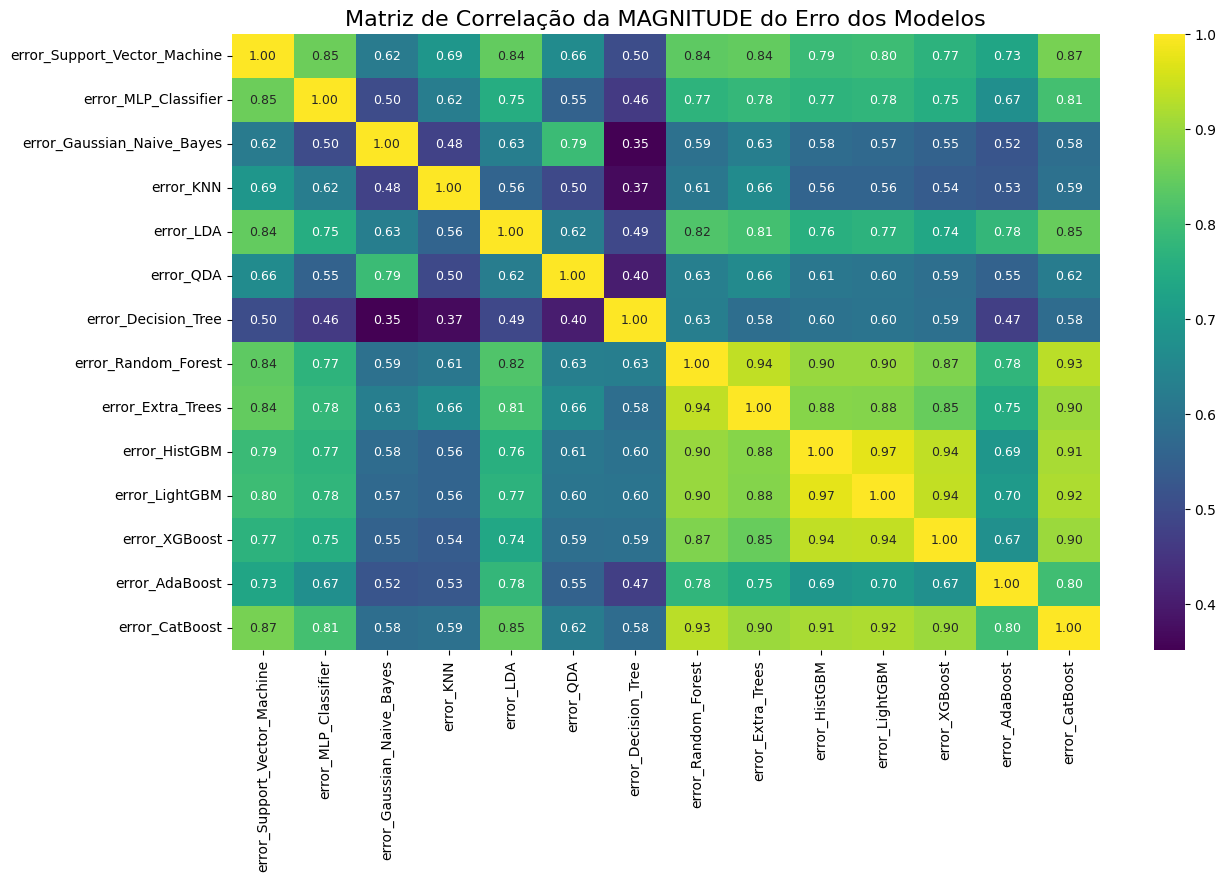

In [100]:
error_magnitude_df = pd.DataFrame()
all_model_names = list(models_sensitive_to_distribution.keys()) + list(models_robust_to_distribution.keys())
y_real_numeric = cv_probabilities_df['y_real'].astype(int)

for name in all_model_names:
    error_col_name = f"error_{name.replace(' ', '_')}"
    error_magnitude_df[error_col_name] = np.abs(cv_probabilities_df[name] - y_real_numeric)

error_correlation = error_magnitude_df.corr()

plt.figure(figsize=(14, 8))
sns.heatmap(error_correlation, annot=True, cmap='viridis', fmt=".2f", annot_kws={"size": 9})
plt.title('Matriz de Correlação da MAGNITUDE do Erro dos Modelos', fontsize=16)
plt.show()

Analisando o heatmap de correlação das probabilidades previstas com o valor real, observamos nitidamente que alguns modelos apresentam comportamentos muito semelhantes. Modelos como Random Forest, CatBoost, XGBoost e AdaBoost demonstram altíssima correlação entre si, com valores que variam entre 0,75 e 0,95+, indicando que compartilham padrões de confiança e erro bastante similares.

Diante disso, a estratégia ideal não é escolher múltiplos modelos de um mesmo grupo arquitetural, pois isso introduz redundância no ensemble. Em vez disso, devemos buscar um equilíbrio entre desempenho individual e diversidade, selecionando modelos que, além de obterem bons resultados em métricas-chave (como o Recall), também apresentem baixa correlação entre suas previsões — o que indica que cometem erros diferentes e, portanto, são mais complementares.

Assim, a escolha dos modelos que irão compor a stack deve considerar dois critérios principais:

- Desempenho individual robusto, priorizando métricas relevantes ao objetivo (neste caso, o Recall);
- Diversidade preditiva, representada pela baixa correlação entre as previsões ou erros dos modelos, maximizando o ganho potencial do meta-modelo ao combinar informações não redundantes.

#### Stacking Ensemble

Após identificarmos o `AdaBoost` como o modelo individual de melhor performance, realizaremos um último experimento para testar se um ensemble do tipo Stacking pode extrair ainda mais poder preditivo. Diferente de um ensemble de votação, o `StackingClassifier` utiliza um "meta-modelo" para aprender a combinar de forma inteligente as previsões de um conjunto de modelos base.

Foram escolhidos três modelos de base com arquiteturas fundamentalmente diferentes, cada um com uma forma distinta de "enxergar" o problema:

1. `AdaBoostClassifier`: Representa o poder dos modelos de boosting baseados em árvores, que são excelentes em capturar relações complexas e não-lineares. Além disso, é particularmente eficaz quando há features interagindo de forma sutil, pois foca iterativamente nas amostras mais difíceis de classificar.
2. `QuadraticDiscriminantAnalysis`: Assume uma matriz de covariância diferente para cada classe, o que permite modelar fronteiras de decisão curvas e relações não-lineares.
3. `SVC (Support Vector Classifier)`: Representa os modelos de margem máxima, que constroem uma fronteira ótima para separar as classes. É eficaz na identificar padrões não-lineares e relações complexas entre variáveis, mesmo em alta dimensionalidade.

Os modelos acima possuem uma combinação de correlações de erros mais baixa se comparado com os outros (como pode ser visualizado no heatmap).

A hipótese é que, ao combinar as "opiniões" distintas desses três modelos, um meta-modelo (`LogisticRegression`) pode aprender a ponderar suas forças e fraquezas, corrigindo os erros individuais de cada um e resultando em um classificador final mais robusto e com maior poder de detecção (Recall).

In [101]:
pipeline_ada = ImblearnPipeline(steps=[
    ('feature_engineering', FeatureEngineer(drop_weak_features=True)),
    ('scaler', StandardScaler()),
    ('resampling', ADASYN(random_state=42)),
    ('classifier', AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42))
])

pipeline_qda = ImblearnPipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('dynamic_preprocessor', DynamicPreprocessor()),
    ('resampling', ADASYN(random_state=42)),
    ("classifier", QuadraticDiscriminantAnalysis())
])

pipeline_svc = ImblearnPipeline(steps=[
    ('feature_engineering', FeatureEngineer(drop_weak_features=True)),
    ('dynamic_preprocessor', DynamicPreprocessor()),
    ('resampling', ADASYN(random_state=42)),
    ('classifier', SVC(probability=True, random_state=42))
])

estimators = [
    ('adaboost', pipeline_ada),
    ('mlp', pipeline_qda),
    ('logistic', pipeline_svc )
]

meta_classifier = LogisticRegression(random_state=42, max_iter=1000)

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_classifier,
    cv=cv_strategy,
    passthrough=False
)

scores = cross_val_score(stacking_model, X_train, y_train, cv=cv_strategy, scoring='recall')

print(f"Recall Médio (CV=5): {np.mean(scores):.4f}")  
print(f"Desvio Padrão dos Scores: {np.std(scores):.4f}")
print("---"*20)
print(f"Recall Médio do melhor modelo individualmente (AdaBoost) (CV=5): {results_df['Recall_Medio'][0]:.4f}")  
print(f"Desvio Padrão dos Scores do melhor modelo individualmente (AdaBoost): {results_df['Desvio_Padrao'][0]:.4f}")

Recall Médio (CV=5): 0.8645
Desvio Padrão dos Scores: 0.0196
------------------------------------------------------------
Recall Médio do melhor modelo individualmente (AdaBoost) (CV=5): 0.8804
Desvio Padrão dos Scores do melhor modelo individualmente (AdaBoost): 0.0226


Conforme os resultados da validação cruzada, o `StackingClassifier` (Recall Médio: 0.8654) não conseguiu superar a performance do melhor modelo individual, o `AdaBoostClassifier`(Recall Médio: 0.8804).

A razão pela qual um ensemble mais complexo não superou o modelo individual geralmente se deve a um fator principal:
- O modelo base principal (neste caso, o AdaBoost) já é extremamente poderoso e bem-ajustado ao problema. Após a robusta engenharia de features que realizamos, o AdaBoost foi capaz de capturar a grande maioria dos padrões preditivos, deixando pouca "informação residual" ou "erros corrigíveis" para os outros modelos contribuírem de forma significativa. A tentativa do meta-modelo de combinar as previsões, nesse cenário, acabou introduzindo mais ruído do que sinal, resultando em uma performance ligeiramente inferior.

Portanto, a nossa experimentação e validação confirmam que, para este problema e com este conjunto de features, o pipeline final utilizando o modelo `AdaBoostClassifier` individualmente é a solução de melhor performance e a recomendada para a implementação.

## Tunagem de Hyperparametros

Após a fase de experimentação ter identificado o `AdaBoostClassifier` como o modelo de maior performance para o nosso objetivo, o passo final é realizar um "ajuste fino" de seus principais hiperparâmetros. O objetivo desta etapa é extrair o máximo de poder preditivo do algoritmo, encontrando a configuração que melhor se adapta à estrutura dos nossos dados.

Para isso, empregaremos uma estratégia de otimização avançada:

- **Técnica**: Busca Bayesiana (`BayesSearchCV`). Diferente de uma busca em grade que testa todas as combinações, a abordagem Bayesiana é mais eficiente, utilizando os resultados de iterações passadas para "aprender" e focar a busca em regiões mais promissoras do espaço de hiperparâmetros.
- **Métrica de Otimização**: O processo será guiado para maximizar o **Recall** da classe `Dropout`. Esta é uma decisão que serve para alinhar o modelo ao objetivo de negócio de minimizar o número de Falsos Negativos, garantindo que a maior quantidade possível de alunos em risco seja identificada.
- **Hiperparâmetros-Alvo**: A otimização focará nos parâmetros mais influentes do AdaBoost:
    - `n_estimators`: O número de árvores de decisão que compõem o ensemble.
    - `learning_rate`: A taxa de aprendizado, que controla o peso que cada árvore tem na correção dos erros da anterior.
    - `estimator__max_depth`: A profundidade máxima de cada árvore de decisão base, controlando a complexidade do modelo.

In [102]:
if os.path.exists('./best_adaboost.pkl'):
    best_adaboost_pipeline = joblib.load('best_adaboost.pkl')
else:
    base_estimator = DecisionTreeClassifier(class_weight='balanced', random_state=42)

    ada_model = AdaBoostClassifier(estimator=base_estimator, random_state=42)

    search_space_adaboost = {
        'classifier__n_estimators': Integer(50, 1000),
        'classifier__learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'classifier__estimator__max_depth': Integer(1, 5) # Profundidade da árvore base
    }

    full_pipeline_ada = ImblearnPipeline(steps=[
        ('feature_engineer', FeatureEngineer(drop_weak_features=True)),
        ('scaler', StandardScaler()),
        ('resampling', ADASYN(random_state=42)),
        ('classifier', ada_model)
    ])

    # Configuração da Busca Bayesiana focada em RECALL
    optimizer_ada = BayesSearchCV(
        estimator=full_pipeline_ada,
        search_spaces=search_space_adaboost,
        n_iter=96,
        cv=cv_strategy,
        scoring='recall',
        random_state=42,
        verbose=0
    )

    optimizer_ada.fit(X_train, y_train)
    best_adaboost_pipeline = optimizer_ada.best_estimator_
    joblib.dump(best_adaboost_pipeline, 'best_adaboost.pkl')
    
    print(f"Melhor Recall (cross-val): {optimizer_ada.best_score_:.4f}")
    print("Melhores Hiperparâmetros encontrados:")
    for param, value in optimizer_ada.best_params_.items():
        print(f"  - {param}: {value}")

In [16]:
set_config(display='diagram')
best_adaboost_pipeline

Pipeline(steps=[('feature_engineer', FeatureEngineer()),
                ('scaler', StandardScaler()),
                ('resampling', ADASYN(random_state=42)),
                ('classifier',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                     max_depth=2,
                                                                     random_state=42),
                                    learning_rate=0.0432315460587612,
                                    n_estimators=861, random_state=42))])

Melhores Hiperparâmetros Encontrados:

- `n_estimators`: 861
- `learning_rate`: 0.0432
- `estimator__max_depth`: 2


A combinação de parâmetros encontrada revela o perfil de um modelo de boosting de alta performance:

1. **Aprendizado Gradual e Cauteloso**: A busca encontrou uma combinação clássica de uma taxa de aprendizado baixa (`learning_rate=0.043`) com um número alto de estimadores (`n_estimators=861`). Isso indica que o modelo ideal aprende de forma incremental, onde cada nova árvore faz apenas pequenas correções nos erros da anterior. Essa abordagem tende a gerar modelos mais robustos e com melhor capacidade de generalização, evitando ajustes bruscos e overfitting.

2. **Complexidade Controlada**: O otimizador preferiu árvores base com profundidade `max_depth=2` em vez de `max_depth=1` (o padrão). Isso permite que o modelo capture interações simples entre duas features, dando-lhe um pouco mais de poder preditivo do que os "decision stumps" padrão, mas sem correr o risco de criar árvores excessivamente complexas que poderiam não generalizar bem.

### Análise de importância do Modelo

In [103]:
final_model_pipeline = best_adaboost_pipeline.fit(X_train, y_train)
feature_engineer_trained = final_model_pipeline.named_steps['feature_engineer']

X_train_enriched = feature_engineer_trained.transform(X_train)
classifier_trained = final_model_pipeline.named_steps['classifier']

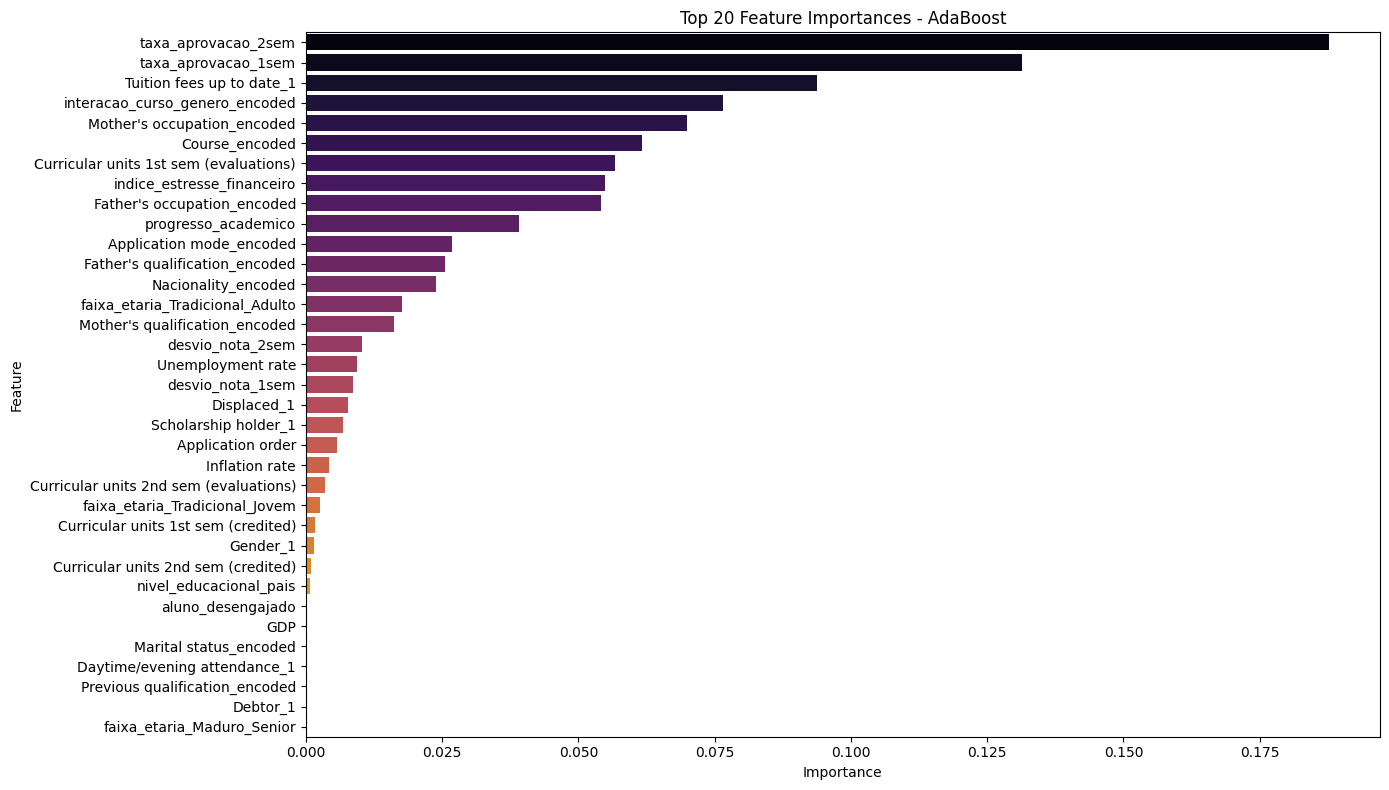

In [104]:
model = best_adaboost_pipeline.named_steps['classifier']

# Usa diretamente as colunas do DataFrame
feature_names = X_train_enriched.columns
importances_gini = model.feature_importances_

# Monta o DataFrame de importâncias
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances_gini
}).sort_values(by='importance', ascending=False)

# Plota as top 20 features
plt.figure(figsize=(14, 8))
sns.barplot(data=feature_importance_df, x='importance', y='feature', palette='inferno')
plt.title('Top 20 Feature Importances - AdaBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

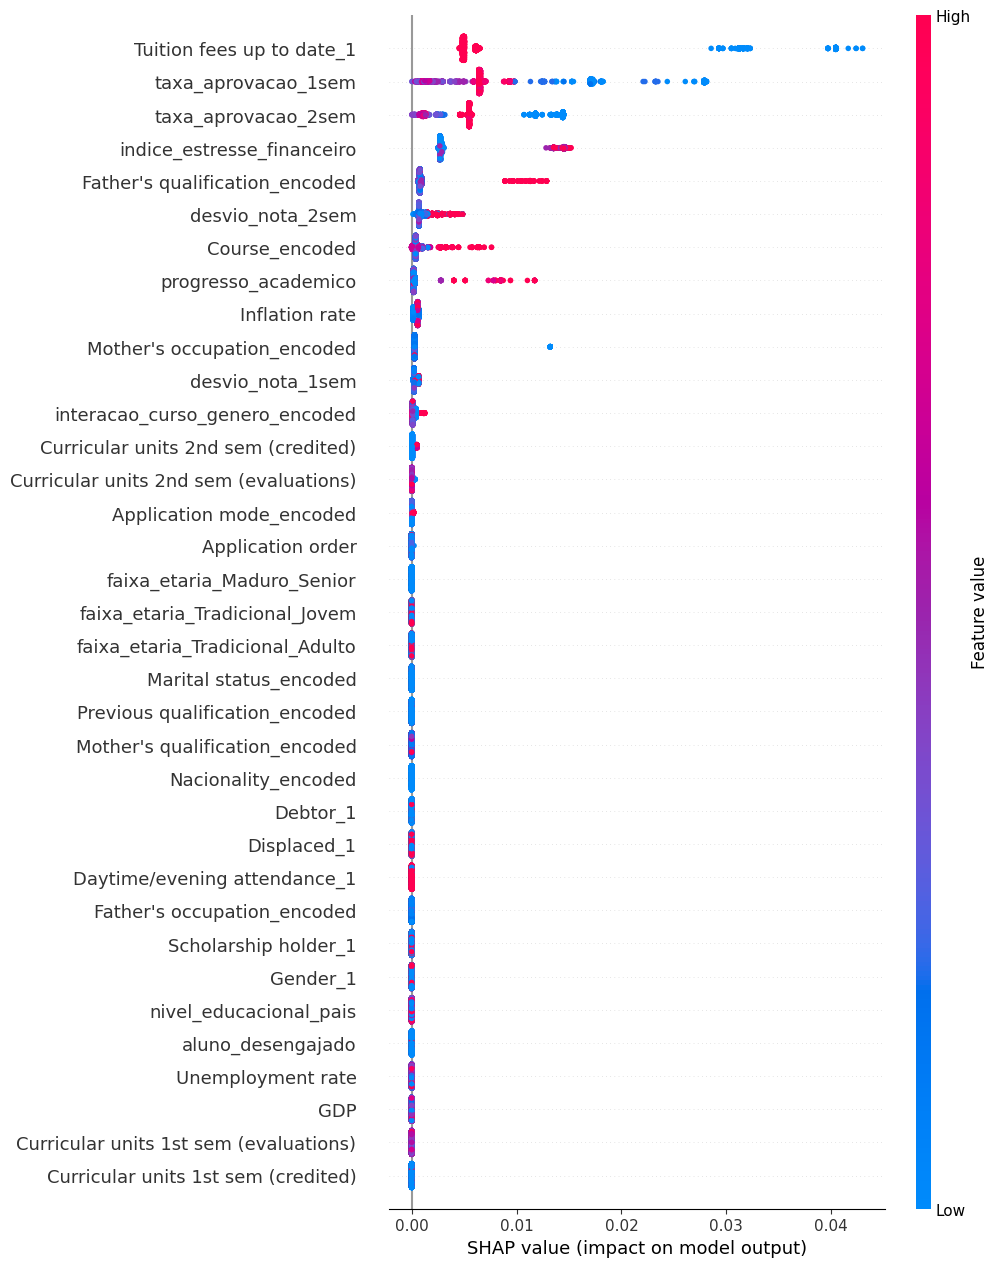

In [105]:
shap.initjs()

explainer = shap.Explainer(classifier_trained, X_train_enriched)
shap_values = explainer(X_train_enriched)

shap.plots.beeswarm(shap_values[:, :, 1].abs, max_display=35)

In [106]:
importance_shap = shap_values.abs.mean(axis=0).values.mean(axis=1) 
features_shap = X_train_enriched.columns[importance_shap > 0].tolist()
features_gini = feature_importance_df[feature_importance_df['importance'] > 0]['feature'].tolist()

gini_only_features = set(features_gini) - set(features_shap)

print(f"Total de features importantes para Gini: {len(features_gini)}")
print(f"Total de features importantes para SHAP: {len(features_shap)}")
print("-" * 50)
print(f"Features importantes APENAS para o Gini (candidatas à remoção):")
pprint(list(gini_only_features))

Total de features importantes para Gini: 28
Total de features importantes para SHAP: 16
--------------------------------------------------
Features importantes APENAS para o Gini (candidatas à remoção):
['nivel_educacional_pais',
 'Curricular units 1st sem (evaluations)',
 'Unemployment rate',
 'Curricular units 1st sem (credited)',
 "Mother's qualification_encoded",
 'Scholarship holder_1',
 'faixa_etaria_Tradicional_Adulto',
 'faixa_etaria_Tradicional_Jovem',
 "Father's occupation_encoded",
 'Gender_1',
 'Nacionality_encoded',
 'Displaced_1']


Comparando Gini vs. SHAP: Por que a Diferença?

- **Importância Gini** (`.feature_importances_`): Mede a frequência e a eficácia com que uma feature foi usada para criar "nós" puros durante a construção das árvores de decisão. Ele pode dar um valor de importância pequeno, mas não-zero, a features que foram usadas em algum momento, mesmo que seu impacto final na previsão seja mínimo.
- **Importância SHAP** (Média do Valor Absoluto): Mede o impacto real de uma feature na saída final do modelo. Se uma feature é usada em uma árvore, mas seu efeito é cancelado por outras árvores no ensemble, seu valor SHAP médio pode ser zero.

**Conclusão-chave**: O SHAP é considerado uma métrica mais confiável e verdadeira da importância preditiva de uma feature. O fato de ele ter identificado um conjunto menor (16 features) sugere que as outras 12 features, embora usadas na construção do modelo, têm um impacto líquido negligenciável ou nulo nas previsões finais.

In [107]:
pipeline_shap = ImblearnPipeline(steps=[
    ('feature_engineer', FeatureEngineer(drop_weak_features=True)),
    ('feature_selector', ColumnTransformer(
        transformers=[
            ("selector", "passthrough", features_shap)
        ], 
        remainder='drop'
    )),
    ('scaler', StandardScaler()),
    ('resampling', ADASYN(random_state=42)),
    ('classifier', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(
            class_weight=classifier_trained.estimator.class_weight,
            max_depth=classifier_trained.estimator.max_depth,
            random_state=42
        ),
        learning_rate=classifier_trained.learning_rate,
        n_estimators=classifier_trained.n_estimators,
        random_state=42
    ))
])

# Faz predições por cross-validation
y_pred_shap = cross_val_predict(
    pipeline_shap,
    X_train,
    y_train,
    cv=cv_strategy
)

y_pred_default = cross_val_predict(
    best_adaboost_pipeline,
    X_train,
    y_train,
    cv=cv_strategy
)

# Gera o classification report
display(pd.DataFrame(classification_report(y_train, y_pred_shap, digits=3, output_dict=True)).T.rename(index={'0': 'graduate','1': 'dropout'}))
print('----'*20)
display(pd.DataFrame(classification_report(y_train, y_pred_default, digits=3, output_dict=True)).T.rename(index={'0': 'graduate','1': 'dropout'}))

,precision,recall,f1-score,support
graduate,0.932618,0.885116,0.908246,1767.000000
dropout,0.834556,0.900616,0.866328,1137.000000
accuracy,0.891185,0.891185,0.891185,0.891185
macro avg,0.883587,0.892866,0.887287,2904.000000
weighted avg,0.894224,0.891185,0.891834,2904.000000


--------------------------------------------------------------------------------


,precision,recall,f1-score,support
graduate,0.929287,0.892473,0.910508,1767.000000
dropout,0.842585,0.894459,0.867747,1137.000000
accuracy,0.893251,0.893251,0.893251,0.893251
macro avg,0.885936,0.893466,0.889128,2904.000000
weighted avg,0.895341,0.893251,0.893766,2904.000000


Foi possível criar um modelo mais simples e eficiente (o `pipeline_shap`, que usa menos features) que:

1. Melhorou a métrica mais importante para o problema de negócio: o **Recall**. Ou seja, ele consegue identificar uma porcentagem ainda maior de alunos em risco.
2. Manteve um desempenho virtualmente idêntico em **F1-Score** e **Acurácia**. A diferença de 0.2% é estatisticamente insignificante e está dentro da margem de variação da validação cruzada.

Em Machine Learning, existe um princípio fundamental conhecido como a **Navalha de Ockham**: dentre as hipóteses (ou modelos) com poder preditivo semelhante, a mais simples é quase sempre a melhor.

Modelos mais simples são preferíveis porque são:

- **Mais Rápidos**: Exigem menos tempo para treinar e para fazer previsões.
- **Mais Fáceis de Manter**: Têm menos dependências de features de entrada, o que os torna mais robustos em um ambiente de produção.
- **Menos Propensos a Overfitting**: Ao remover features com baixo poder preditivo, reduzimos a chance de o modelo aprender "ruído" nos dados de treino.

## Comparação das Métricas Finais 


Gerando previsões de CV para as curvas de análise...


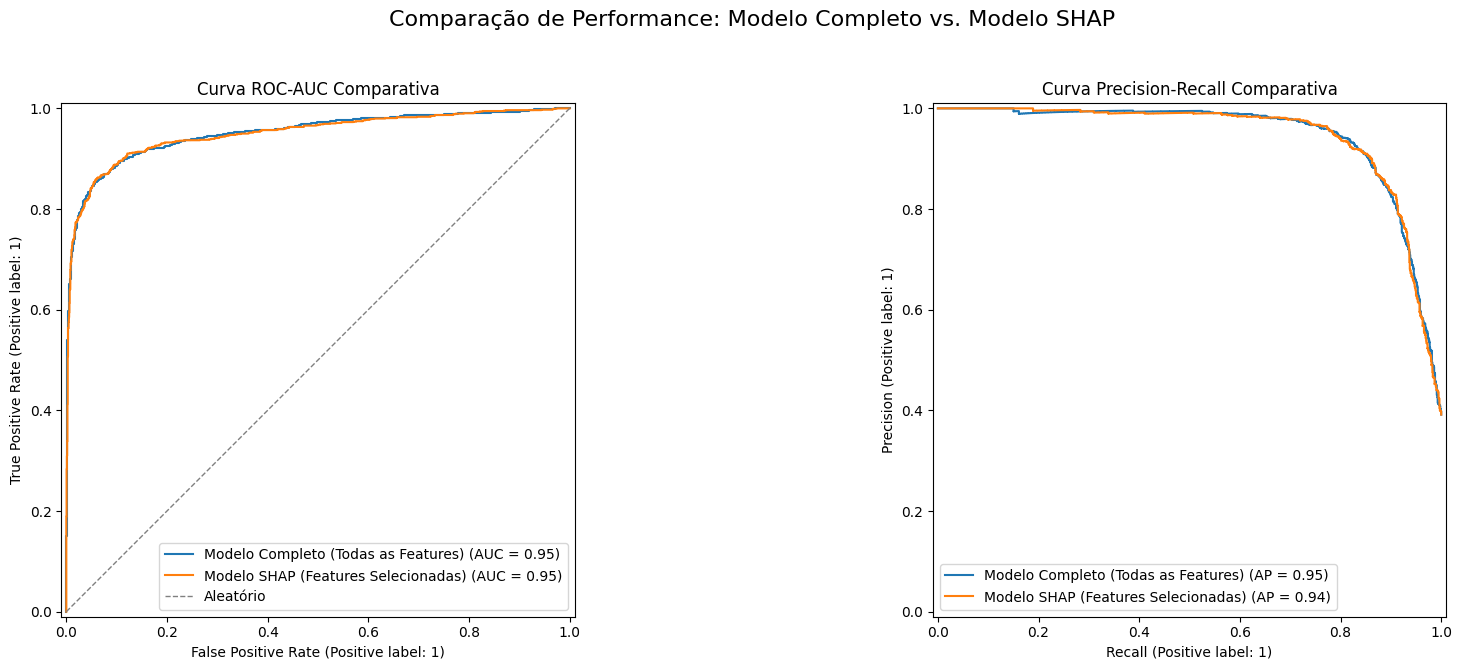

In [97]:
print("\nGerando previsões de CV para as curvas de análise...")
# Previsões para o modelo com features SHAP
y_probas_shap = cross_val_predict(
    pipeline_shap, 
    X_train, 
    y_train, 
    cv=cv_strategy, 
    method='predict_proba',
)

# Previsões para o modelo padrão (todas as features)
y_probas_default = cross_val_predict(
    best_adaboost_pipeline, 
    X_train, 
    y_train, 
    cv=cv_strategy, 
    method='predict_proba',
)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Comparação de Performance: Modelo Completo vs. Modelo SHAP', fontsize=16)

RocCurveDisplay.from_predictions(
    y_train, 
    y_probas_default[:, 1], # Probabilidades da classe positiva
    ax=axes[0], 
    name="Modelo Completo (Todas as Features)"
)

RocCurveDisplay.from_predictions(
    y_train, 
    y_probas_shap[:, 1], 
    ax=axes[0], 
    name="Modelo SHAP (Features Selecionadas)"
)
axes[0].plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--', label='Aleatório')
axes[0].set_title("Curva ROC-AUC Comparativa")
axes[0].legend()

PrecisionRecallDisplay.from_predictions(
    y_train, 
    y_probas_default[:, 1], 
    ax=axes[1], 
    name="Modelo Completo (Todas as Features)"
)

PrecisionRecallDisplay.from_predictions(
    y_train, 
    y_probas_shap[:, 1], 
    ax=axes[1], 
    name="Modelo SHAP (Features Selecionadas)"
)
axes[1].set_title("Curva Precision-Recall Comparativa")
axes[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- **Curva ROC-AUC (O Empate Técnico)**:
    - O AUC mede a capacidade geral do modelo de distinguir um aluno que vai evadir de um que vai se formar. Um resultado idêntico significa que o poder de discriminação fundamental dos dois modelos é exatamente o mesmo. As 12 features extras que o modelo completo utiliza não adicionam nenhum poder de separação geral entre as classes.

- **Curva Precision-Recall (A Vantagem Marginal)**:
    - É aqui que vemos a única, e muito pequena, vantagem do modelo completo (AP = 0.95 vs 0.94). A Área sob a Curva Precision-Recall (AP) é mais sensível em datasets desbalanceados. Essa diferença de 0.01 nos diz que o modelo completo, ao longo de todos os limiares de decisão, consegue manter uma precisão ligeiramente maior para diferentes níveis de recall. As 12 features extras, embora não melhorem a separação geral, oferecem uma pequena ajuda para refinar as probabilidades e evitar alguns Falsos Positivos.

Vale a pena manter um modelo mais complexo, com mais features e mais caro de manter, por uma melhoria de 1% em uma única métrica, quando outra métrica principal (ROC AUC) mostra que eles são idênticos?

Não, pois:

1. **Performance Estatisticamente Equivalente**: A diferença de 1% no AP é marginal e muito provavelmente não é estatisticamente significativa. O poder de discriminação geral é idêntico. Você não está sacrificando performance real.

2. **O Custo da Complexidade**: O modelo simples (com 16 features) é objetivamente melhor que o complexo (com 28+ features) em todos os aspectos operacionais: é mais rápido para treinar, mais rápido para fazer previsões, mais barato de hospedar, mais fácil de manter e mais fácil de explicar.

3. **Princípio da Parcimônia (Navalha de Ockham)**: Entre dois modelos com poder preditivo virtualmente igual, escolha sempre o mais simples. Ele é mais robusto, mais generalizável e menos propenso a ter aprendido ruído específico dos dados de treino.

**Conclusão**: Vamos usar o modelo com menos features para as previsões e avaliações finais.

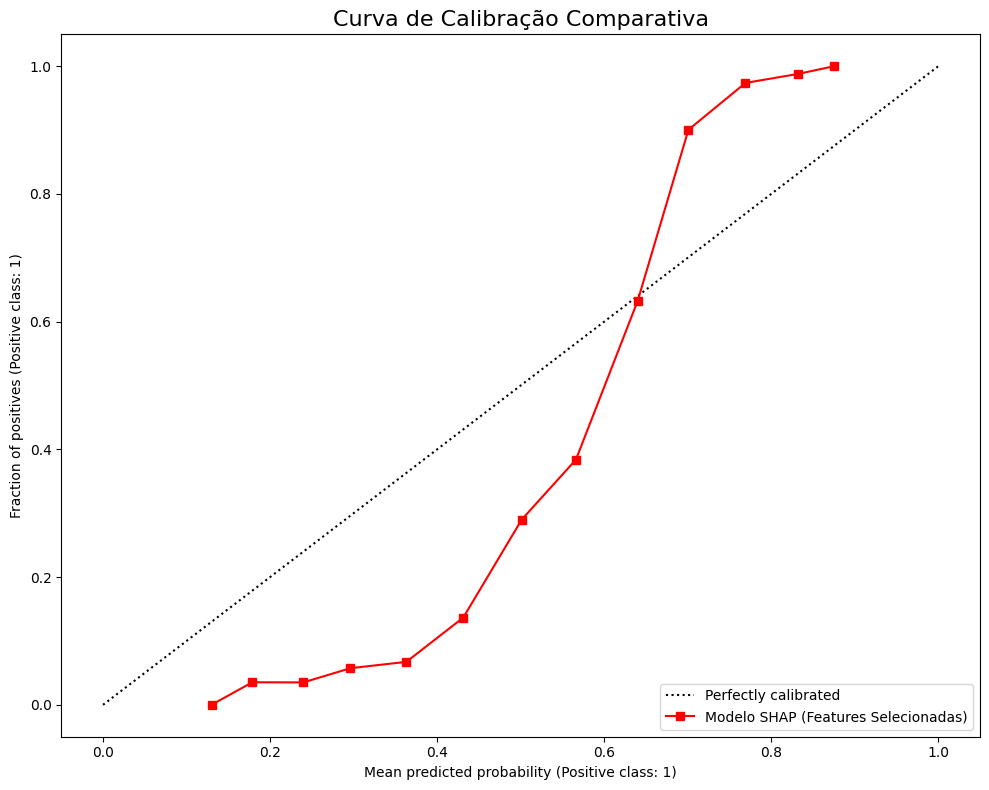

In [108]:
fig, ax = plt.subplots(figsize=(10, 8))

CalibrationDisplay.from_predictions(
    y_train, 
    y_probas_shap[:, 1], 
    n_bins=15,
    ax=ax,
    name="Modelo SHAP (Features Selecionadas)",
    color='red'
)

ax.set_title("Curva de Calibração Comparativa", fontsize=16)
plt.tight_layout()
plt.show()

O gráfico, com o formato de "S", retorna dois insights de negócio muito importantes sobre o modelo AdaBoost:

- **Confiança nos Extremos**: O modelo é excelente em identificar os extremos.
    - **Risco Baixo**: Quando ele prevê uma probabilidade baixa (ex: 20%), a chance real de evasão é ainda menor (quase 0%). Isso significa que você pode confiar plenamente que os alunos classificados como de baixo risco estão, de fato, seguros.
    - **Risco Alto**: Quando ele prevê uma probabilidade alta (ex: 80%), a chance real de evasão é ainda maior (quase 100%). Isso significa que os alunos no topo da lista de risco são, com certeza, os casos mais críticos.


Em que casos devemos calibrar o nosso modelo? 

- **Objetivo**: Se o objetivo da área de negócios for "criar um programa de intervenção com diferentes níveis de intensidade. Precisamos saber quais alunos têm mais de 80% de chance de evadir para uma tutoria individual, quais estão entre 60-80% para um workshop em grupo, e quais estão entre 50-60% para receber um e-mail de apoio", então a **calibração é fundamental**.

- **Justificativa**: Para criar essas faixas e tomar decisões de negócio baseadas nelas, você precisa confiar que uma previsão de "80%" realmente corresponde a uma probabilidade próxima de 80% no mundo real. Um modelo não calibrado é superconfiante; ele pode dar uma probabilidade de 60% para um aluno cuja chance real de evasão é de apenas 30%. Usá-lo para criar faixas de risco levaria a uma alocação de recursos completamente equivocada.

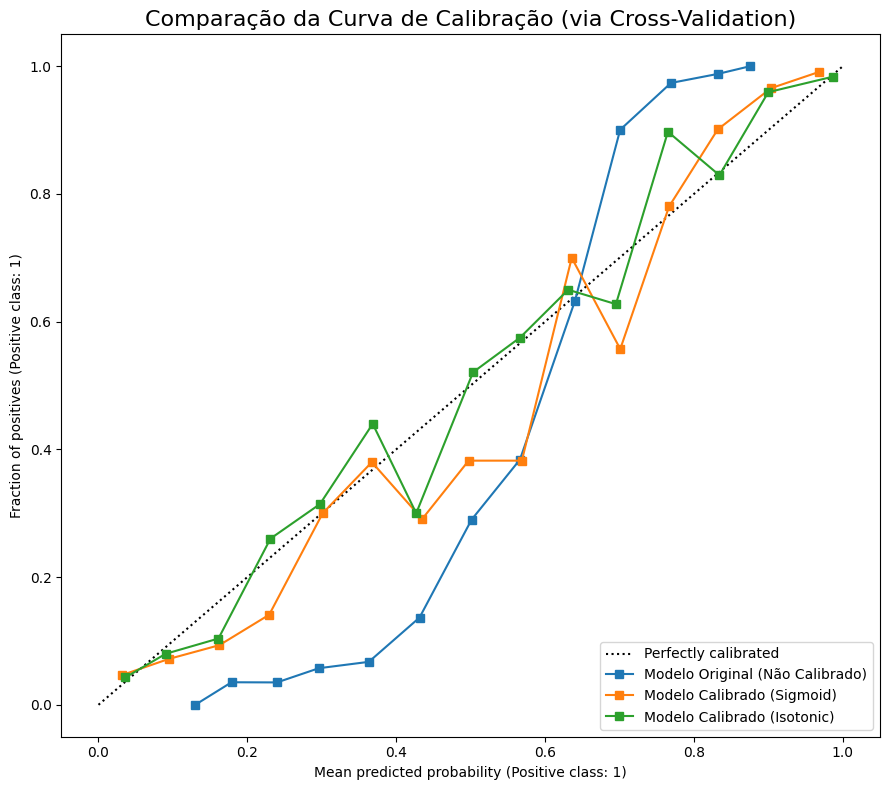

In [109]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

calibrated_sigmoid_pipeline_cv = CalibratedClassifierCV(
    pipeline_shap, 
    method='sigmoid', 
    cv=cv_strategy  # 3 folds internos para a calibração é um bom valor, mais rápido.
)

calibrated_isotonic_pipeline_cv = CalibratedClassifierCV(
    pipeline_shap, 
    method='isotonic', 
    cv=cv_strategy
)

y_probas_sigmoid_calibrated_cv = cross_val_predict(
    calibrated_sigmoid_pipeline_cv,
    X_train,
    y_train,
    cv=cv_strategy,
    method='predict_proba',
)

y_probas_isotonic_calibrated_cv = cross_val_predict(
    calibrated_isotonic_pipeline_cv,
    X_train,
    y_train,
    cv=cv_strategy,
    method='predict_proba',
)

fig, ax = plt.subplots(figsize=(9, 8))

CalibrationDisplay.from_predictions(
    y_train, 
    y_probas_shap[:, 1], # Probabilidades da classe positiva
    n_bins=15, 
    ax=ax,
    name="Modelo Original (Não Calibrado)",
)

CalibrationDisplay.from_predictions(
    y_train, 
    y_probas_sigmoid_calibrated_cv[:, 1], 
    n_bins=15,
    ax=ax,
    name="Modelo Calibrado (Sigmoid)",
)

CalibrationDisplay.from_predictions(
    y_train, 
    y_probas_isotonic_calibrated_cv[:, 1], 
    n_bins=15,
    ax=ax,
    name="Modelo Calibrado (Isotonic)",
)

ax.set_title("Comparação da Curva de Calibração (via Cross-Validation)", fontsize=16)
plt.tight_layout()
plt.show()

- **Modelo Original (Curva Azul)**: Confirma o que já sabíamos. O modelo base é um ótimo classificador (ele ordena bem os alunos por risco), mas um péssimo estimador de probabilidades devido ao seu excesso de confiança, com a curva em formato de "S" bem acentuado.

- **Modelo Calibrado (Sigmoid - Curva Laranja)**: Vemos uma melhora significativa. A calibração sigmoide (também conhecida como Platt Scaling) fez um ótimo trabalho em "suavizar" o excesso de confiança do modelo, trazendo a curva para muito mais perto da linha diagonal ideal.

- **Modelo Calibrado (Isotonic - Curva Verde)**: É a vencedora indiscutível. A curva de regressão isotônica, por ser mais flexível e não assumir uma forma específica, conseguiu se ajustar quase perfeitamente aos dados. Em praticamente todas as faixas de probabilidade, a previsão do modelo calibrado corresponde à realidade. O pequeno "zigue-zague" é normal para este método, pois ele se ajusta aos dados de forma pontual.



Com uma calibração, nós podemos transformar o modelo de um classificador binário em um sistema de gestão de risco.

Com as probabilidades calibradas pelo método isotônico, a instituição de ensino pode, com alta confiança, implementar estratégias de intervenção por faixas de risco (ex: Risco Alto > 80%, Risco Médio 60-80%), sabendo que esses números correspondem fielmente à realidade. Isso otimiza recursos, personaliza a abordagem e maximiza o impacto das ações de retenção.

## Avaliações Finais (Dados de Teste)

#### Comparação entre o modelo calibrado (isotonic) e o não calibrado

--- Treinando e Avaliando os Modelos Finais no Conjunto de Teste ---
Processando: AdaBoost (Não Calibrado)...
Processando: AdaBoost (Calibrado Isotonic)...


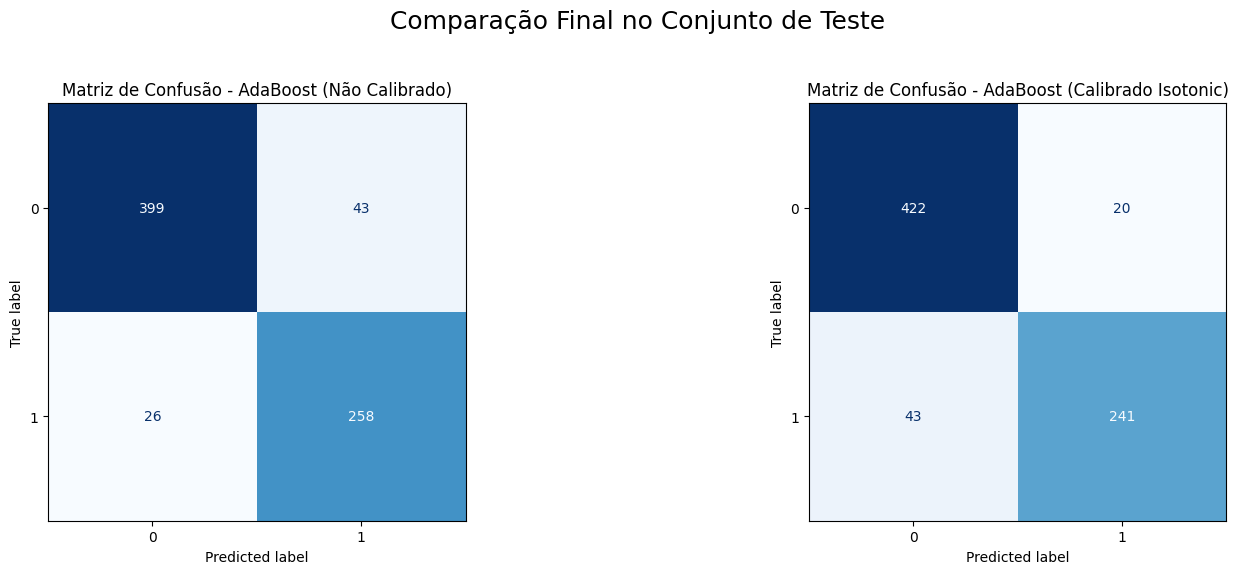


--- Tabela Comparativa de Performance Final ---


,Precisão (Dropout),Recall (Dropout),F1-Score (Dropout)
AdaBoost (Não Calibrado),0.8571,0.9085,0.8821
AdaBoost (Calibrado Isotonic),0.9234,0.8486,0.8844


In [110]:
pipelines_to_compare = {
    "AdaBoost (Não Calibrado)": pipeline_shap,
    "AdaBoost (Calibrado Isotonic)": calibrated_isotonic_pipeline_cv
}

final_results = {}
fitted_pipelines = {}


print("--- Treinando e Avaliando os Modelos Finais no Conjunto de Teste ---")
for name, pipeline in pipelines_to_compare.items():
    print(f"Processando: {name}...")
    
    fitted_model = pipeline.fit(X_train, y_train)
    fitted_pipelines[name] = fitted_model
    
    y_pred = fitted_model.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    dropout_metrics = report.get('1', {}) # Foco na classe 'Dropout'
    
    final_results[name] = {
        'Precisão (Dropout)': dropout_metrics.get('precision', 0),
        'Recall (Dropout)': dropout_metrics.get('recall', 0),
        'F1-Score (Dropout)': dropout_metrics.get('f1-score', 0)
    }


fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Comparação Final no Conjunto de Teste', fontsize=18)

for i, (name, pipeline) in enumerate(fitted_pipelines.items()):
    ax = axes[i]
    ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f'Matriz de Confusão - {name}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


results_df = pd.DataFrame.from_dict(final_results, orient='index')
results_df = results_df.round(4)

print("\n--- Tabela Comparativa de Performance Final ---")
display(results_df)

O resultado é um clássico trade-off:

| Métrica / Característica           | Modelo Não Calibrado           | Modelo Calibrado (Isotonic)   |
|-----------------------------------|--------------------------------|-------------------------------|
| Recall (Detecção)                 | **0.9085 (Superior)**          | 0.8486                        |
| Precisão (Eficiência)            | 0.8571                         | **0.9234 (Superior)**         |
| F1-Score (Equilíbrio)             | 0.8821                         | **0.8844 (Ligeiramente Superior)** |
| Confiabilidade da Probabilidade   | Baixa (Superconfiante)         | **Alta (Realista)**           |


- O Modelo **Não Calibrado** é a nossa melhor "rede de segurança". Ele é superior em encontrar o maior número possível de alunos em risco (**Recall mais alto**).
- O Modelo **Calibrado** é a nossa ferramenta de "alta eficiência". Ele gera muito menos alarmes falsos, garantindo que o tempo da equipe de apoio seja melhor aproveitado (**Precisão mais alta**).

##### Cenários de Aplicação: Qual Modelo para Qual Estratégia?

A escolha entre os dois modelos não é técnica, mas sim uma decisão de negócio baseada nos recursos e na filosofia da instituição.

- **Cenário A**: "Estratégia de Ranking e Alcance Máximo" - Escolhendo o Modelo Não Calibrado
    - **Quando usar**: Se o objetivo principal da instituição é simplesmente gerar uma lista ordenada de alunos com maior risco para que uma equipe de apoio possa contatá-los sequencialmente, do mais provável ao menos provável.
    - **Como funciona**: Neste cenário, o valor exato da probabilidade não é tão importante quanto o ranking que ela gera. O modelo não calibrado, com seu Recall superior de quase 91%, é a melhor ferramenta para garantir que a "rede de segurança" seja a maior possível, capturando o máximo de alunos que precisam de ajuda.
    - **Vantagem**: Máxima detecção de casos de risco.
    - **Desvantagem**: A equipe de apoio lidará com mais "alarmes falsos" (precisão de 86%), e não será possível diferenciar um aluno com "muito risco" de um com "risco extremo" com base na probabilidade.


- **Cenánário B**: "Estratégia de Gestão de Risco por Níveis" - Escolhendo o Modelo Calibrado
    - **Quando usar**: Se a instituição deseja criar uma estratégia de intervenção sofisticada, segmentada e baseada em níveis de urgência, alocando recursos de forma mais inteligente.
    - **Como funciona**: Com as probabilidades confiáveis e realistas do modelo calibrado, a instituição pode criar faixas de ação com segurança:
        - **Risco Crítico (Probabilidade > 80%)**: Intervenção imediata e pessoal por um conselheiro sênior.
        - **Risco Alto (Probabilidade 60-80%)**: Convocação para um workshop de apoio ou tutoria em grupo.
        - **Risco Moderado (Probabilidade 50-60%)**: Envio de um e-mail informativo com recursos e canais de ajuda.
    - **Vantagem**: Esta abordagem é muito mais eficiente e personalizada. Ela não apenas prevê, mas quantifica o risco de forma confiável.
    - **Desvantagem**: Aceita-se que a "rede de segurança" total é um pouco menor (Recall de 85%), o que pode gerar um grande impacto, já que falsos negativos podem gerar um impacto financeiro significativo para a instituição de ensino.

##### Conclusão:

Após uma análise detalhada da performance dos modelos finais no conjunto de teste, a decisão estratégica é selecionar o Modelo **AdaBoost Não Calibrado** como a solução final a ser implementada.

Esta escolha parte da premissa de que a prioridade máxima para uma instituição de ensino é a maximização da detecção de alunos em risco, o que torna o **Recall** a métrica fundamental. Nesse contexto, o objetivo de evitar **Falsos Negativos** (deixar um aluno em risco passar despercebido) é considerado mais crítico do que prevenir **Falsos Positivos** (intervir em um aluno que não precisava) e/ou ter probabilidades perfeitamente calibradas, que são objetivos secundários.

O modelo não calibrado demonstrou ser a ferramenta mais eficaz para esta missão principal, alcançando um **Recall** de **90,9%** para a classe `Dropout`, superando a versão calibrada.

Embora o modelo calibrado ofereça maior precisão, a escolha pelo modelo não calibrado é justificada pela sua superior capacidade de criar a maior "rede de segurança" possível, oferecendo uma oportunidade de ajuda a quase **91%** dos alunos que evadiriam. Portanto, o modelo recomendado é aquele que prioriza o alcance e a detecção, alinhando-se diretamente com uma estratégia de retenção estudantil proativa e de máximo impacto.

In [111]:
final_model = pipelines_to_compare["AdaBoost (Não Calibrado)"]
final_model

Pipeline(steps=[('feature_engineer', FeatureEngineer()),
                ('feature_selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['Application order',
                                                   'Curricular units 2nd sem '
                                                   '(credited)',
                                                   'Curricular units 2nd sem '
                                                   '(evaluations)',
                                                   'Inflation rate',
                                                   'indice_estresse_financeiro',
                                                   'desvio_nota_1sem',
                                                   'desvio_nota_2sem',
                                                   'taxa_aprovacao_1sem',
                                                   'taxa_aprovacao_2...
                                                   "Mother's "
                                                   'occupation_encoded',
                                                   'interacao_curso_genero_encoded',
                                                   'Tuition fees up to '
                                                   'date_1'])])),
                ('scaler', StandardScaler()),
                ('resampling', ADASYN(random_state=42)),
                ('classifier',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                     max_depth=2,
                                                                     random_state=42),
                                    learning_rate=0.0432315460587612,
                                    n_estimators=861, random_state=42))])

### Análise eficiência do modelo

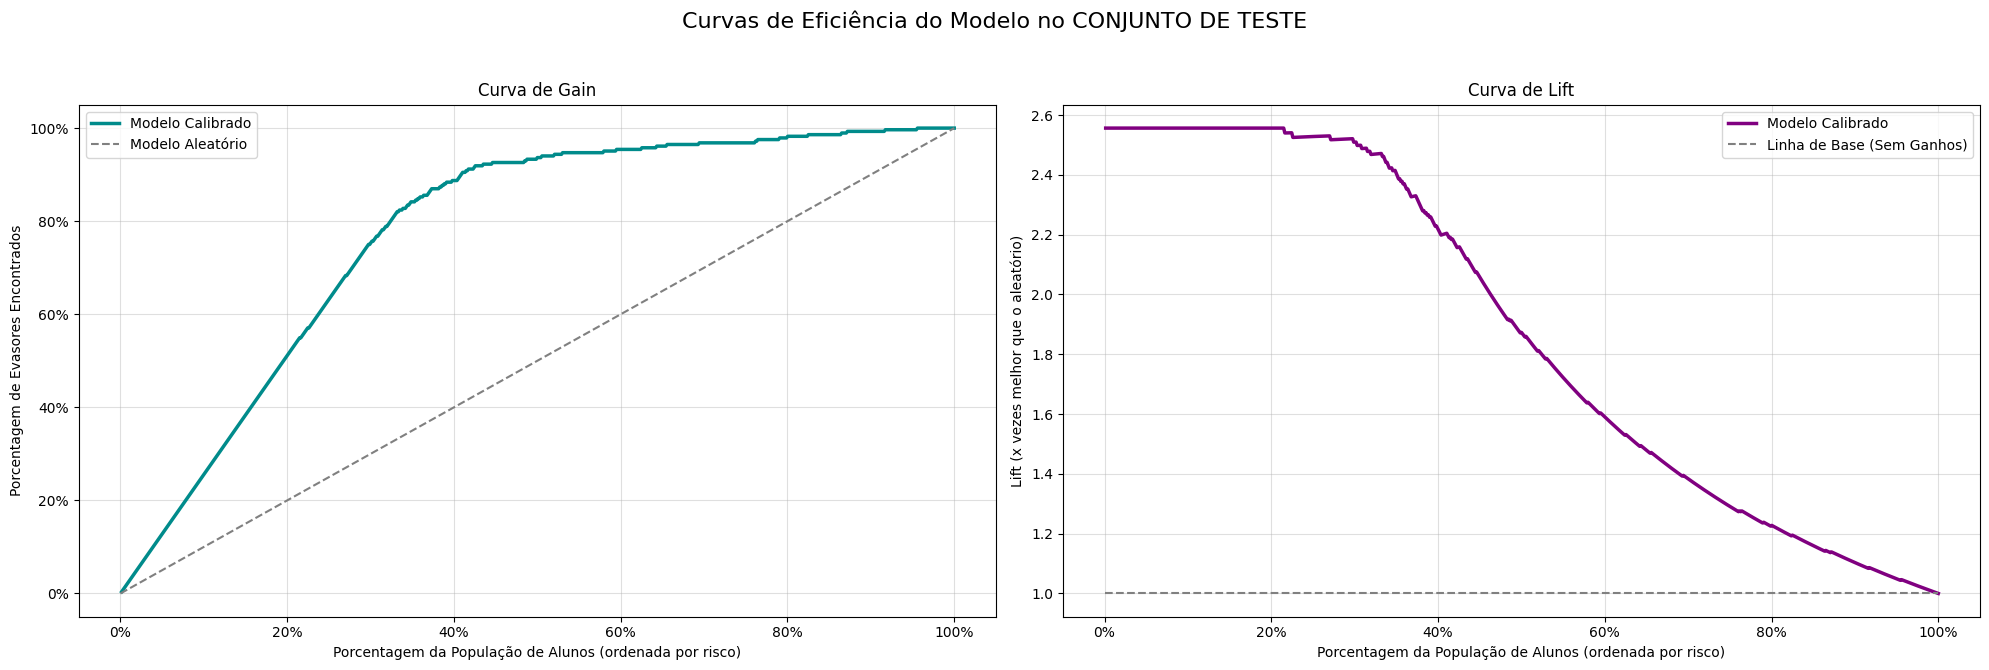

In [112]:
y_probas_test = final_model.predict_proba(X_test)

y_scores = y_probas_test[:, 1]

df_results_test = pd.DataFrame({'y_true': y_test, 'y_score': y_scores})
df_results_test = df_results_test.sort_values(by='y_score', ascending=False)

df_results_test['cumulative_positives'] = df_results_test['y_true'].astype(int).cumsum()
total_positives = df_results_test['y_true'].astype(int).sum()
df_results_test['gain'] = df_results_test['cumulative_positives'] / total_positives

df_results_test['population_percentage'] = np.arange(1, len(df_results_test) + 1) / len(df_results_test)
df_results_test['lift'] = df_results_test['gain'] / df_results_test['population_percentage']

fig, axes = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Curvas de Eficiência do Modelo no CONJUNTO DE TESTE', fontsize=16)

axes[0].plot(df_results_test['population_percentage'], df_results_test['gain'], label='Modelo Calibrado', color='darkcyan', lw=2.5)
axes[0].plot([0, 1], [0, 1], label='Modelo Aleatório', color='grey', linestyle='--')
axes[0].set_xlabel("Porcentagem da População de Alunos (ordenada por risco)")
axes[0].set_ylabel("Porcentagem de Evasores Encontrados")
axes[0].set_title('Curva de Gain')
axes[0].legend()
axes[0].grid(True, alpha=0.4)
axes[0].xaxis.set_major_formatter(PercentFormatter(1.0))
axes[0].yaxis.set_major_formatter(PercentFormatter(1.0))

axes[1].plot(df_results_test['population_percentage'], df_results_test['lift'], label='Modelo Calibrado', color='purple', lw=2.5)
axes[1].plot([0, 1], [1, 1], label='Linha de Base (Sem Ganhos)', color='grey', linestyle='--')
axes[1].set_xlabel("Porcentagem da População de Alunos (ordenada por risco)")
axes[1].set_ylabel("Lift (x vezes melhor que o aleatório)")
axes[1].set_title('Curva de Lift')
axes[1].legend()
axes[1].grid(True, alpha=0.4)
axes[1].xaxis.set_major_formatter(PercentFormatter(1.0))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


#### Interpretação da Curva de Gain (O "Quanto Encontramos")

O gráfico à esquerda mostra o quão rápido o modelo consegue encontrar os alunos que realmente pertencem à classe Dropout.

- **Ponto Chave 1 (Eficiência Máxima)**: Ao focar nos 20% dos alunos com maior risco apontados pelo modelo, a instituição consegue encontrar e atuar sobre aproximadamente 50% de todos os alunos que iriam evadir.
- **Ponto Chave 2 (Cobertura Ampla)**: Com um esforço um pouco maior, contatando os 40% de maior risco, a equipe de apoio já alcançaria cerca de 90% do público-alvo (os futuros evasores).

**Insight Estratégico**: Isso demonstra uma ótima eficiência. A instituição não precisa de uma abordagem que "atire para todos os lados". Com um esforço focado em menos da metade da população estudantil em risco, é possível cobrir mais de 90% do problema da evasão.

#### Interpretação da Curva de Lift (O "Quão Melhores Somos")

O gráfico à direita quantifica o poder do modelo em comparação com uma abordagem aleatória.

- **Ponto Chave 1 (Lift Inicial)**: O "lift" inicial de aproximadamente 2.6 significa que um aluno escolhido do topo da lista de risco do modelo tem 2.6 vezes mais chance de ser um evasor real do que um aluno escolhido ao acaso da população geral.
- **Ponto Chave 2 (Lift Sustentado)**: O lift se mantém bem acima de 2.0 mesmo quando consideramos 30-40% da população. Isso mostra que o modelo não é bom apenas em encontrar os casos óbvios, mas também em ranquear eficientemente os alunos de risco moderado.

**Insight Estratégico**: O modelo é um "multiplicador de eficiência" para a equipe de apoio. Cada hora de trabalho gasta contatando alunos da lista do modelo é, em média, 2.5 vezes mais produtiva do que seria com uma abordagem não direcionada.

#### Conclusão

Com base nesses gráficos, um gestor pode decidir: "Neste semestre, temos recursos para intervir ativamente em 30% dos nossos alunos. O modelo nos garante que, ao fazer isso, estaremos alcançando cerca de 80% do nosso problema real de evasão, o que é um ótimo retorno sobre o investimento".

# Explicabilidade do Modelo

## SHAP

In [ ]:
shap.initjs()

# final_model_pipeline = final_model.fit(X_train, y_train)
# feature_engineer_trained = final_model.named_steps['feature_engineer']

# X_train_final_df = feature_engineer_trained.transform(X_train)
# X_test_final_df = feature_engineer_trained.transform(X_test)

# classifier_trained = final_model.named_steps['classifier']

# explainer = shap.Explainer(classifier_trained, X_train_final_df)
# shap_values = explainer(X_test_final_df)

# shap.plots.beeswarm(shap_values[:, :, 1].abs, max_display=35)